<!--NOTEBOOK_INFORMATION-->
<img id="r-1060983" data-claire-element-id="1061343" src="http://www.siteduzero.com/favicon.ico" alt="Image utilisateur">
    <p>
        **<font color='#D2691E'size="6">Tags recommendation (5/7)</font>**.
    </p>
<p>
    This notebook explores the combination between two unsupervised learning methods : LDA and Word2Vec
</p>
<p>
    The "LDA part" is striclty the same as in the notebook "3_Unsupervised_learning_LDA", so you can directly jump in the section "IX) Word2Vec model training on the corpus of messages" if you already read it.
</p>
<p>
    Word2Vec allows to build a word embedding in which words become vectors.
</p>
<p>
    I use the word embedding in order to compute similarities between words and tags
</p>
<p>
    I finally combine the LDA and Word2Vec models in order to make tags recommendations
</p>

<p>
    <center>
        **<font color='	#D2691E'size="6">PLAN</font>**
    </center>
</p>

<p>
        **<font color='#D2691E'size="4">0) Libraries, functions and datasources import</font>**
</p>
<p>
        **<font color='#D2691E'size="4">I) LDA Implementation</font>**
</p>
<p>
        **<font color='#D2691E'size="4">II) Topics distributions for the corpus elements</font>**
</p>
<p>
        **<font color='#D2691E'size="4">III) Topics associated to words</font>**
</p>
<p>
        **<font color='#D2691E'size="4">IV) Words associated to Topics</font>**
</p>
<p>
        **<font color='#D2691E'size="4">V) Tags associated to topics</font>**
</p>
<p>
        **<font color='#D2691E'size="4">VI) Building the LDA word/tags similarities matrices</font>**
</p>
<p>
        **<font color='#D2691E'size="4">VII) Topics management</font>**
</p>
<p>
        **<font color='#D2691E'size="4">VIII) LDA main topics</font>**
</p>
<p>
        **<font color='#D2691E'size="4">IX) Word2Vec model training on the corpus of messages</font>**
</p>
<p>
        **<font color='#D2691E'size="4">X) Building the Word2Vec word/tags similarities matrices</font>**
</p>
<p>
        **<font color='#D2691E'size="4">XI) Word2Vec model training on the pure corpus of tag lists</font>**
</p>
<p>
        **<font color='#D2691E'size="4">XII) Generating tags</font>**
</p>
<p>
        **<font color='#D2691E'size="4">XIII) CHECKS on the train perimeter</font>**
</p>
<p>
        **<font color='#D2691E'size="4">XIV) Prediction on the test data</font>**
</p>
<p>
        **<font color='#D2691E'size="4">XV) Tags generation on the test perimeter</font>**
</p>
<p>
        **<font color='#D2691E'size="4">XVI) CHECKS on the test perimeter</font>**
</p>

<p>
        **<font color='#D2691E'size="4">0) Library, functions and datasources import </font>**
</p>

In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

In [2]:
from context import dir_path, datasources_path, enrichment_path, pickles_path, temp_files_path

In [3]:
from functions import aggregate_col_in_list

In [4]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [5]:
df_model= pickle.load(open(pickles_path+"df_model_unsupervised.p", "rb" ))
df_model.head()

,id,Text,tag_list,corpus,text_len,unique_text_len,n_tags,tags_matching,n_tags_matching,matching_score
0,0,while applying opacity to a form should we use...,"[csharp, winforms]",apply opacity form use decimal double value us...,29,21,2,{},0,0.000000
1,1,percentage width child element in absolutely p...,"[html, css, internetexplorer7]",percentage width child element absolutely posi...,44,23,3,{css},1,0.333333
2,2,how do i calculate someone age in csharp given...,"[net, csharp, datetime]",calculate age csharp datetime represent person...,9,7,3,"{csharp, datetime}",2,0.666667
3,3,calculate relative time in csharp given a spec...,"[datetime, csharp]",calculate relative time csharp datetime value ...,16,12,2,"{csharp, datetime}",2,1.000000
4,4,determine a user timezone is there any standar...,"[javascript, browser, html]",determine user timezone web server determine u...,14,10,3,{},0,0.000000


In [6]:
L_train_indexes = pickle.load(open(pickles_path+"L_train_indexes.p", "rb" ))
L_test_indexes = pickle.load(open(pickles_path+"L_test_indexes.p", "rb" ))

In [7]:
L_frequent_tags = pickle.load(open(pickles_path+"L_frequent_tags.p", "rb" ))

In [8]:
df_train = df_model[df_model['id'].isin(L_train_indexes)]
df_test = df_model[df_model['id'].isin(L_test_indexes)]

<p>
        **<font color='#D2691E'size="4">I) LDA Implementation</font>**
</p>

In [9]:
from sklearn.decomposition import LatentDirichletAllocation

In [10]:
L_corpus = list(df_train['corpus'])

In [11]:
L_corpus[0:10]

['percentage width child element absolutely position parent internet explorer 7 absolutely position div children relatively position div use width child div collapse width internet explorer 7 firefox safari use pixel width parent relatively position percentage width child besides width child area css specification cover',
 'calculate age csharp datetime represent person calculate age year',
 'calculate relative time csharp datetime value relative time like 2 hour ago 3 ago month ago',
 'msdnmicrosoftcom enus library msdnmicrosoftcom enus library net',
 'fill dataset datatable linq query set expose linq query asmx web service usually business tier return type dataset datatable serialize transport asmx linq query populate type dataset datatable linq query public static string db new new sproc linq var query dr select dr copy linq query resultset datatable return get set linq query dataset datatable alternatively linq query expose asmx web service',
 'binary data mysql store binary data m

In [12]:
len(L_corpus)

3939

In [13]:
N_FEATURES = 1000
N_TOP_WORDS = 20
N_COMPONENTS = 10

In [14]:
# Use count (raw term count) features for LDA.
print("Extracting count features for LDA...")
count_vectorizer = CountVectorizer(max_df=0.95, min_df=10, max_features=N_FEATURES)
start_time = time.time()
count = count_vectorizer.fit_transform(L_corpus)
print("--- %s seconds ---" % (time.time() - start_time))

Extracting count features for LDA...
--- 0.13555622100830078 seconds ---


In [15]:
lda = LatentDirichletAllocation(n_components=N_COMPONENTS, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
start_time = time.time()
lda.fit(count)
print("--- %s seconds ---" % (time.time() - start_time))

print("\nTopics in LDA model:")
vectorizer_feature_names = count_vectorizer.get_feature_names()
print_top_words(lda, vectorizer_feature_names, N_TOP_WORDS)

--- 5.675031900405884 seconds ---

Topics in LDA model:
Topic #0: array ruby session size number print tags perl using option rails menu reference tag iphone cost count like filter openid
Topic #1: user application use log users using access net get like update directory store login error machine expression regex web problem
Topic #2: class public use like csharp thread new using interface object library design method code static language private methods java objects
Topic #3: database sql data table server query list select like key use tables using mysql change set get stored db field
Topic #4: javascript form html text button browser image page like use css using code content firefox user get tag div jquery
Topic #5: use visual control build get studio windows code application using file like version problem app net program process project time
Topic #6: web service development use project using start testing windows document time email developer experience get python services envir

In [16]:
#Thanks to the "vectorizer_feature_names" column we can now make a DataFrame which contains the schema of the training words space
#We will need this schema in order to work with the test datas.
df_train_words_space_schema = pd.DataFrame(columns = vectorizer_feature_names)
df_train_words_space_schema

,09,10,100,11,12,15,2000,2003,2005,2007,...,wouldnt,wpf,wrap,xml,xp,year,yes,yet,youre,zip


<p>
        **<font color='#D2691E'size="4">II) Topics distributions for the corpus elements</font>**
</p>

In [17]:
results = lda.transform(count)
results[0:10]

array([[0.00312506, 0.00312509, 0.00312524, 0.00312507, 0.97187407,
        0.00312512, 0.00312509, 0.00312509, 0.00312505, 0.00312512],
       [0.0125    , 0.01250008, 0.2606771 , 0.01250146, 0.01250041,
        0.01250036, 0.01250097, 0.63931254, 0.01250676, 0.01250031],
       [0.00769284, 0.00769272, 0.00769358, 0.00769325, 0.00769275,
        0.00769304, 0.5227736 , 0.41568238, 0.00769282, 0.00769301],
       [0.0125    , 0.01250191, 0.88749234, 0.0125    , 0.01250001,
        0.01250116, 0.01250097, 0.01250044, 0.01250057, 0.01250261],
       [0.00212771, 0.00212805, 0.10448136, 0.65946818, 0.00212788,
        0.00212781, 0.11094395, 0.11233928, 0.00212793, 0.00212784],
       [0.01250003, 0.01250182, 0.01250017, 0.88748844, 0.01250001,
        0.01250003, 0.0125    , 0.01250111, 0.01250001, 0.0125084 ],
       [0.01000082, 0.01000521, 0.01000024, 0.90998078, 0.01000076,
        0.01000386, 0.01000014, 0.01000429, 0.01000206, 0.01000182],
       [0.01111588, 0.01111283, 0.0111132

In [18]:
L_main_topics = []
for sub_result in results:
    L_main_topics.append(np.argmax(sub_result))
L_main_topics[0:10]

[4, 7, 6, 2, 3, 3, 3, 7, 3, 2]

In [19]:
df_corpus_topics = pd.DataFrame(results)
df_corpus_topics['id'] = list(df_train['id'])
df_corpus_topics['main_topic'] = L_main_topics
df_corpus_topics['corpus'] = L_corpus
df_corpus_topics.head()

,0,1,2,3,4,5,6,7,8,9,id,main_topic,corpus
0,0.003125,0.003125,0.003125,0.003125,0.971874,0.003125,0.003125,0.003125,0.003125,0.003125,1,4,percentage width child element absolutely posi...
1,0.012500,0.012500,0.260677,0.012501,0.012500,0.012500,0.012501,0.639313,0.012507,0.012500,2,7,calculate age csharp datetime represent person...
2,0.007693,0.007693,0.007694,0.007693,0.007693,0.007693,0.522774,0.415682,0.007693,0.007693,3,6,calculate relative time csharp datetime value ...
3,0.012500,0.012502,0.887492,0.012500,0.012500,0.012501,0.012501,0.012500,0.012501,0.012503,5,2,msdnmicrosoftcom enus library msdnmicrosoftcom...
4,0.002128,0.002128,0.104481,0.659468,0.002128,0.002128,0.110944,0.112339,0.002128,0.002128,6,3,fill dataset datatable linq query set expose l...


In [20]:
L_topics = []
for topic in range(N_COMPONENTS):
    L_topics.append(topic)
df_corpus_topics

,0,1,2,3,4,5,6,7,8,9,id,main_topic,corpus
0,0.003125,0.003125,0.003125,0.003125,0.971874,0.003125,0.003125,0.003125,0.003125,0.003125,1,4,percentage width child element absolutely posi...
1,0.012500,0.012500,0.260677,0.012501,0.012500,0.012500,0.012501,0.639313,0.012507,0.012500,2,7,calculate age csharp datetime represent person...
2,0.007693,0.007693,0.007694,0.007693,0.007693,0.007693,0.522774,0.415682,0.007693,0.007693,3,6,calculate relative time csharp datetime value ...
3,0.012500,0.012502,0.887492,0.012500,0.012500,0.012501,0.012501,0.012500,0.012501,0.012503,5,2,msdnmicrosoftcom enus library msdnmicrosoftcom...
4,0.002128,0.002128,0.104481,0.659468,0.002128,0.002128,0.110944,0.112339,0.002128,0.002128,6,3,fill dataset datatable linq query set expose l...
5,0.012500,0.012502,0.012500,0.887488,0.012500,0.012500,0.012500,0.012501,0.012500,0.012508,7,3,binary data mysql store binary data mysql
6,0.010001,0.010005,0.010000,0.909981,0.010001,0.010004,0.010000,0.010004,0.010002,0.010002,9,3,error mysql trigger trigger update table error...
7,0.011116,0.011113,0.011113,0.011112,0.011112,0.011115,0.011113,0.899981,0.011111,0.011113,11,7,unload using actionscript 3 unload memory usin...
8,0.001177,0.083762,0.078401,0.829599,0.001177,0.001177,0.001177,0.001177,0.001177,0.001177,12,3,change sql server table monitor sql server dat...
9,0.002083,0.002084,0.981247,0.002083,0.002084,0.002084,0.002084,0.002084,0.002084,0.002084,13,2,reliable timer console application aware net f...


<p>
        **<font color='#D2691E'size="4">III) Topics associated to words</font>**
</p>

In [21]:
df_topics_words = pd.DataFrame(lda.components_, columns=vectorizer_feature_names)
df_topics_words

,09,10,100,11,12,15,2000,2003,2005,2007,...,wouldnt,wpf,wrap,xml,xp,year,yes,yet,youre,zip
0,0.103474,0.107576,20.737489,0.103116,0.136588,0.770526,0.103119,0.135065,0.103687,0.105382,...,0.110380,0.102807,0.103060,0.107050,0.103065,0.127212,6.643383,5.294577,0.113076,0.113238
1,33.865200,10.515539,0.531688,45.372411,0.167440,1.478246,1.156856,2.630512,0.109022,3.974220,...,3.062500,0.494370,0.606119,6.931727,2.338900,1.198486,7.634270,2.884173,3.167534,1.966990
2,0.105798,0.309782,0.572635,0.107795,12.448043,0.110231,0.136871,0.104785,0.120630,2.605401,...,14.581565,16.127666,7.613787,0.249964,0.104479,4.520195,7.028190,23.820139,13.979300,0.123963
3,0.102993,20.410050,1.557704,5.504171,16.312033,14.869995,36.042196,0.113860,119.389924,0.113412,...,4.315596,0.114016,0.118886,5.945345,0.134577,7.888052,5.182785,7.648985,6.553722,0.202632
4,0.199546,16.066649,11.571985,0.109271,5.738387,0.103615,0.103074,0.103518,0.103257,7.701724,...,0.819856,14.369279,21.321582,16.299960,0.142305,0.640359,1.943686,2.772696,0.122471,0.103053
5,0.113853,2.664549,0.131774,5.009105,0.185448,4.454349,0.154246,0.252354,88.198587,34.422479,...,10.156694,86.789524,0.224232,0.379325,10.499890,16.050709,19.166448,24.325807,4.802710,32.517486
6,0.294342,0.246386,3.099869,0.108541,0.164583,4.947371,0.103820,54.503041,6.915169,14.427719,...,0.247926,0.103605,0.249042,10.516880,65.272471,34.743064,0.551828,7.873808,1.478388,0.105644
7,0.112561,43.015345,5.053899,11.664854,8.292029,14.045323,0.103751,0.110855,0.111186,0.105826,...,1.881380,0.103778,7.532165,90.725047,0.106554,42.017342,1.853784,0.114410,0.335549,2.138683
8,0.102854,8.668551,0.103848,0.109000,0.127229,0.103650,0.105601,0.104766,0.103136,0.578521,...,4.804041,0.115740,0.112948,0.113581,0.105616,0.105959,0.103910,0.445785,0.352646,0.105085
9,0.110476,23.339465,8.587382,4.404695,1.731505,0.175872,7.461443,0.351514,4.696005,0.292572,...,7.083296,0.115250,15.206358,152.171550,9.347358,6.600883,9.889462,18.722353,15.258600,0.121741


In [22]:
#We can see that the topics weights in the words space are not normalized : 
#belong the sklearn documentation (http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)
#the "components_" attribute can be viewed as pseudocount that represents the number of times word j was assigned to topic i.
#It can also be viewed as distribution over the words for each topic after normalization
#=> I choose to normalize the pseudo-counts of each words over the topics in order to get the weight of each topic for words
for column in df_topics_words.columns:
    column_sum = np.sum(df_topics_words[column])
    df_topics_words[column] = df_topics_words[column].apply(lambda x : x/column_sum)

<p>
        **<font color='#D2691E'size="4">IV) Words associated to Topics</font>**
</p>

In [23]:
df_words_topics = df_topics_words.T
df_words_topics.head()

,0,1,2,3,4,5,6,7,8,9
09,0.002947,0.964516,0.003013,0.002933,0.005683,0.003243,0.008383,0.003206,0.002929,0.003146
10,0.000858,0.083894,0.002471,0.162832,0.128181,0.021258,0.001966,0.343179,0.069158,0.186203
100,0.399195,0.010235,0.011023,0.029986,0.222760,0.002537,0.059672,0.097287,0.001999,0.165306
11,0.001422,0.625887,0.001487,0.075927,0.001507,0.069098,0.001497,0.160910,0.001504,0.060760
12,0.003015,0.003696,0.274771,0.360063,0.126666,0.004093,0.003633,0.183034,0.002808,0.038220


In [24]:
df_topics_words['sql']

0    0.000142
1    0.000757
2    0.000234
3    0.994193
4    0.000196
5    0.000170
6    0.000235
7    0.000158
8    0.000183
9    0.003733
Name: sql, dtype: float64

In [25]:
df_words_topics[3].sort_values(ascending=False).head()

table           0.997024
sql             0.994193
tables          0.993813
foreign         0.984466
relationship    0.982640
Name: 3, dtype: float64

In [26]:
df_words_topics.loc[L_frequent_tags,][0:10]

c:\python\python36\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,0,1,2,3,4,5,6,7,8,9
csharp,0.000532,0.019604,0.446732,0.042958,0.014183,0.073891,0.098253,0.159410,0.041774,0.102663
net,0.000177,0.249168,0.111414,0.001110,0.001884,0.287819,0.141848,0.063025,0.047890,0.095665
aspnet,0.000226,0.117219,0.000305,0.000395,0.001004,0.041626,0.000391,0.000344,0.829655,0.008834
java,0.004251,0.039270,0.311857,0.000237,0.014025,0.000528,0.073050,0.022619,0.031553,0.502609
sqlserver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
javascript,0.000298,0.000314,0.001602,0.000302,0.983123,0.011481,0.000305,0.000561,0.000441,0.001573
c++,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
php,0.104794,0.231798,0.000311,0.000740,0.016879,0.000333,0.189128,0.338050,0.009067,0.108900
sql,0.000142,0.000757,0.000234,0.994193,0.000196,0.000170,0.000235,0.000158,0.000183,0.003733
python,0.111770,0.038596,0.285211,0.003955,0.034338,0.000565,0.366367,0.000391,0.000321,0.158486


In [27]:
#We can see that some tags don't have weights : it must be dued to the splitting in train and test
L_matching_lda_tags = [word for word in df_words_topics.index if word in L_frequent_tags]
L_missing_lda_tags = [word for word in L_frequent_tags if not word in L_matching_lda_tags]

print("The LDA model has %s tags coordinates in the topics space | %s tags are missing"%(len(L_matching_lda_tags),len(L_missing_lda_tags)))

The LDA model has 121 tags coordinates in the topics space | 144 tags are missing


In [28]:
#We need to have coordinates in the topic space for each tag, so we are going to look after the missing information thanks to
#The original tag_list present in the DataFrame.

<p>
        **<font color='#D2691E'size="4">V) Tags associated to topics</font>**
</p>

<p>We want to denormalize our entry dataframe thanks to the 'tag_list' column :</p>
<img align="left" style="padding-right:10px;" src="./images/develop_illustration.jpg">

In [29]:
#We specify the excution params for  the python script responsible for the multiprocessing : 
execution_params = {'N_PROCS' : 6,
                    'dataframe':df_train[['tag_list','id']],
                   'column_to_develop':'tag_list'}
#We dump our execution params :
pickle.dump(execution_params,open(temp_files_path+"execution_params.p", "wb"))
#And we run the script responsible for the stopwords elimination on different process :  
%run -i multiprocessing_develop.py


#We load the result of the multiprocessing task : 
developped_dataframe = pickle.load(open(temp_files_path+"developped_dataframe.p", "rb" ))

#We clean the temp files dir :
import os
from functions import class_my_files
dict_extensions = class_my_files(temp_files_path)
pickles_temp_files  = dict_extensions['p']
for file_name in pickles_temp_files:
    os.remove(temp_files_path+file_name)

developped_dataframe.sort_values(by='id', inplace=True)
developped_dataframe.rename({'tag_list':'tag'}, axis=1, inplace=True)
developped_dataframe.head()

Multiprocessing
Creating pool with 6 processes

df_append
df_append
df_append
df_append
df_append
df_append
--- 6.446804761886597 seconds ---
the result file is available at : 
 temp_files_path+"developped_dataframe.p"


,tag,id
0,html,1
2,internetexplorer7,1
1,css,1
5,datetime,2
4,csharp,2


In [30]:
#Now the dataframe is denormalized on the 'tag' column, we can compute the average topic weights for each tag :
global_df_corpus_topics = pd.merge(developped_dataframe,df_corpus_topics,how='left',on='id')
global_df_corpus_topics.head()

,tag,id,0,1,2,3,4,5,6,7,8,9,main_topic,corpus
0,html,1,0.003125,0.003125,0.003125,0.003125,0.971874,0.003125,0.003125,0.003125,0.003125,0.003125,4,percentage width child element absolutely posi...
1,internetexplorer7,1,0.003125,0.003125,0.003125,0.003125,0.971874,0.003125,0.003125,0.003125,0.003125,0.003125,4,percentage width child element absolutely posi...
2,css,1,0.003125,0.003125,0.003125,0.003125,0.971874,0.003125,0.003125,0.003125,0.003125,0.003125,4,percentage width child element absolutely posi...
3,datetime,2,0.012500,0.012500,0.260677,0.012501,0.012500,0.012500,0.012501,0.639313,0.012507,0.012500,7,calculate age csharp datetime represent person...
4,csharp,2,0.012500,0.012500,0.260677,0.012501,0.012500,0.012500,0.012501,0.639313,0.012507,0.012500,7,calculate age csharp datetime represent person...


In [31]:
#We first parameter the list  of columns we need for the aggregation :
L_tags_topics = L_topics.copy()
L_tags_topics.append('tag')

In [32]:
#And we aggregate the topics weights by the dataframe's tags
df_tags_topics = global_df_corpus_topics[L_tags_topics].groupby('tag').mean()
df_tags_topics.head()

,0,1,2,3,4,5,6,7,8,9
tag,,,,,,,,,,
64bit,0.031127,0.149170,0.003142,0.028729,0.005670,0.264194,0.285542,0.023961,0.011874,0.196593
actionscript3,0.034123,0.071046,0.100050,0.057784,0.277214,0.102350,0.025715,0.191886,0.013283,0.126547
activedirectory,0.008740,0.524133,0.042735,0.100119,0.007805,0.124921,0.052741,0.045984,0.039258,0.053565
adobe,0.032825,0.006366,0.006365,0.136257,0.388216,0.081826,0.062084,0.036926,0.006365,0.242770
adonet,0.004020,0.089594,0.197186,0.296761,0.024191,0.004020,0.041592,0.063265,0.033978,0.245393


In [33]:
for tag in df_tags_topics.index:
    row_sum = np.sum(df_tags_topics.loc[tag,])
    df_tags_topics.loc[tag,] = df_tags_topics.loc[tag,]/row_sum
df_tags_topics.head()

,0,1,2,3,4,5,6,7,8,9
tag,,,,,,,,,,
64bit,0.031127,0.149170,0.003142,0.028729,0.005670,0.264194,0.285542,0.023961,0.011874,0.196593
actionscript3,0.034123,0.071046,0.100050,0.057784,0.277214,0.102350,0.025715,0.191886,0.013283,0.126547
activedirectory,0.008740,0.524133,0.042735,0.100119,0.007805,0.124921,0.052741,0.045984,0.039258,0.053565
adobe,0.032825,0.006366,0.006365,0.136257,0.388216,0.081826,0.062084,0.036926,0.006365,0.242770
adonet,0.004020,0.089594,0.197186,0.296761,0.024191,0.004020,0.041592,0.063265,0.033978,0.245393


In [34]:
#Finally, the dataframe mapping all tags to their topics weights is :
df_tags_topics = df_tags_topics.loc[L_missing_lda_tags,].append(df_words_topics.loc[L_matching_lda_tags,])
df_tags_topics.head()

,0,1,2,3,4,5,6,7,8,9
sqlserver,0.011851,0.060632,0.021977,0.575279,0.013844,0.047210,0.055897,0.091541,0.017984,0.103786
c++,0.023791,0.046935,0.215839,0.049857,0.036069,0.231474,0.064910,0.149457,0.025507,0.156159
visualstudio,0.015664,0.062068,0.063432,0.041318,0.038426,0.559604,0.090620,0.033648,0.018424,0.076797
c,0.063882,0.037204,0.098559,0.038167,0.045540,0.211660,0.078846,0.281369,0.020066,0.124706
languageagnostic,0.065277,0.042495,0.260128,0.098890,0.061605,0.068292,0.100924,0.137312,0.035664,0.129412


In [35]:
#And we can now append the missing tags in the dataframe which maps all words to their topics : 
df_words_topics = df_words_topics.append(df_tags_topics.loc[L_missing_lda_tags,])
df_words_topics.head()

,0,1,2,3,4,5,6,7,8,9
09,0.002947,0.964516,0.003013,0.002933,0.005683,0.003243,0.008383,0.003206,0.002929,0.003146
10,0.000858,0.083894,0.002471,0.162832,0.128181,0.021258,0.001966,0.343179,0.069158,0.186203
100,0.399195,0.010235,0.011023,0.029986,0.222760,0.002537,0.059672,0.097287,0.001999,0.165306
11,0.001422,0.625887,0.001487,0.075927,0.001507,0.069098,0.001497,0.160910,0.001504,0.060760
12,0.003015,0.003696,0.274771,0.360063,0.126666,0.004093,0.003633,0.183034,0.002808,0.038220


<p>
        **<font color='#D2691E'size="4">VI) Building the LDA word/tags similarities matrices</font>**
</p>

In [36]:
#With this two dataframes, we can compute the similarities between tags and words (with tags) in the topic's space:
X_tags_topics = df_tags_topics.values
X_word_topics = df_words_topics.values
from sklearn.metrics.pairwise import cosine_similarity

df_lda_tags_similarity = pd.DataFrame(cosine_similarity(X_tags_topics),columns=df_tags_topics.index, index=df_tags_topics.index)
df_lda_words_similarity = pd.DataFrame(cosine_similarity(X_word_topics),columns=df_words_topics.index, index=df_words_topics.index)

In [37]:
df_lda_tags_similarity.head()

,sqlserver,c++,visualstudio,c,languageagnostic,versioncontrol,unittesting,macos,userinterface,aspnetmvc,...,validation,vb6,vbnet,video,wcf,windows,winforms,workflow,wpf,xml
sqlserver,1.000000,0.343175,0.207167,0.333305,0.457171,0.315944,0.345513,0.289998,0.220926,0.254977,...,0.037908,0.097280,0.508652,0.050740,0.096282,0.182735,0.184472,0.127091,0.088981,0.268677
c++,0.343175,1.000000,0.747058,0.892837,0.881959,0.745157,0.721514,0.835729,0.836862,0.429640,...,0.146916,0.619275,0.755952,0.603501,0.168044,0.703271,0.515373,0.563315,0.679011,0.554356
visualstudio,0.207167,0.747058,1.000000,0.666890,0.410205,0.684170,0.398127,0.958647,0.699894,0.329520,...,0.132457,0.963160,0.431964,0.199559,0.158931,0.920249,0.479650,0.846045,0.962594,0.165533
c,0.333305,0.892837,0.666890,1.000000,0.765371,0.662235,0.591316,0.745861,0.648888,0.371468,...,0.173490,0.587419,0.535274,0.298628,0.198909,0.634394,0.424024,0.536208,0.569955,0.644169
languageagnostic,0.457171,0.881959,0.410205,0.765371,1.000000,0.574258,0.778987,0.565519,0.791963,0.459303,...,0.196112,0.223641,0.824042,0.722515,0.275485,0.408931,0.411074,0.323474,0.332552,0.529002


In [38]:
df_lda_words_similarity.head()

,09,10,100,11,12,15,2000,2003,2005,2007,...,internetexplorer7,lucene,operatingsystem,passwords,vbscript,linker,recursion,dns,ssis,triggers
09,1.000000,0.191335,0.028548,0.954189,0.014207,0.075646,0.035142,0.056962,0.005690,0.111223,...,0.133834,0.054271,0.063767,0.690061,0.030360,0.013717,0.119962,0.279372,0.015320,0.174229
10,0.191335,1.000000,0.434703,0.444707,0.633274,0.765198,0.441860,0.019146,0.328728,0.127770,...,0.377166,0.650319,0.242591,0.529596,0.674738,0.235644,0.841510,0.393398,0.544832,0.466200
100,0.028548,0.434703,1.000000,0.108148,0.267014,0.231066,0.130685,0.125615,0.068148,0.147661,...,0.488423,0.192781,0.283226,0.474036,0.260173,0.149825,0.382973,0.147793,0.359085,0.116670
11,0.954189,0.444707,0.108148,1.000000,0.187356,0.327357,0.162894,0.050025,0.159073,0.195996,...,0.142884,0.250010,0.161720,0.744624,0.230555,0.153765,0.386005,0.339439,0.158507,0.321221
12,0.014207,0.633274,0.267014,0.187356,1.000000,0.734270,0.715556,0.011806,0.579659,0.101466,...,0.328999,0.827153,0.160681,0.243595,0.566554,0.185881,0.640497,0.224272,0.449535,0.712598


In [39]:
def find_similar_words(similarity_matrix, list_of_terms, number_of_neighbors):
    """
    This function goal is to find similar words for each specific word contained in a list
    It returns a dictionary that maps each word of the list to its more similar neighbors
    - 'similarity_matrix' [pandas.DataFrame]  : A similarity matrix between words
    - 'list_of_terms' [list] : The list of words to use in order to search their neighbors
    - 'number_of_neighbors' [int] : The number of similar words to look for each word contained in "list_of_terms"
    """
    import numpy as np
    L_entities = list(similarity_matrix.index)
    L_indexes = list(range(0,len(L_entities)))
    dict_index_entity = {}
    
    for index, entity in zip(L_indexes,L_entities):
        dict_index_entity[index] = entity
    
    dict_neighbors = {}
    
    for term in list_of_terms:
        L_neighbors = []
        similar_terms = list(similarity_matrix.loc[term,])
        L_neigbors_indexes = sorted(range(len(similar_terms)), key=lambda i: similar_terms[i], reverse=True)[:number_of_neighbors+1]
    
        for index in L_neigbors_indexes:
            entity = dict_index_entity[index]
            if entity!=term:
                L_neighbors.append(entity)
        dict_neighbors[term] = L_neighbors
        
    return(dict_neighbors)

In [40]:
pd.DataFrame(find_similar_words(df_lda_tags_similarity,['c', 'file','database','sql','python','javascript','java'],10))

,c,database,file,java,javascript,python,sql
0,recursion,dataset,filesystems,codereview,flex,webservices,dataset
1,compactframework,mysql,ftp,fileio,flash,architecture,mysql
2,c++,sql,excel,networking,firefox,agile,database
3,cocoa,oracle,configuration,sockets,jquery,objectivec,oracle
4,commandline,storedprocedures,backup,tdd,css,unittesting,storedprocedures
5,xslt,sqlserver2005,git,soap,html,glossary,indexing
6,interop,databasedesign,networking,excel,unicode,resources,list
7,serialization,list,sockets,ftp,dom,projectmanagement,sqlserver2005
8,xcode,indexing,outlook,concurrency,validation,silverlight,databasedesign
9,net20,sqlserver,fileio,filesystems,ajax,concurrency,sqlserver


In [41]:
pd.DataFrame(find_similar_words(df_lda_words_similarity,['c', 'file','database','sql','python','javascript','java'],10))

,c,database,file,java,javascript,python,sql
0,code,join,commit,library,flex,br,tables
1,include,primary,drive,component,flash,suggest,table
2,recursion,procedure,files,msdn,button,future,foreign
3,manual,schema,filesystems,codereview,safari,tutorial,relationship
4,point,query,wait,operation,firefox,become,dataset
5,ignore,dataset,copy,everyone,textbox,technique,procedures
6,initial,procedures,port,checked,ltdiv,research,diff
7,compactframework,key,ftp,utility,typetext,course,schema
8,warn,diff,receive,embedded,jquery,webservices,procedure
9,get,mysql,mobile,remember,div,curious,query


In [42]:
df_corr = df_tags_topics.corr(method='spearman')

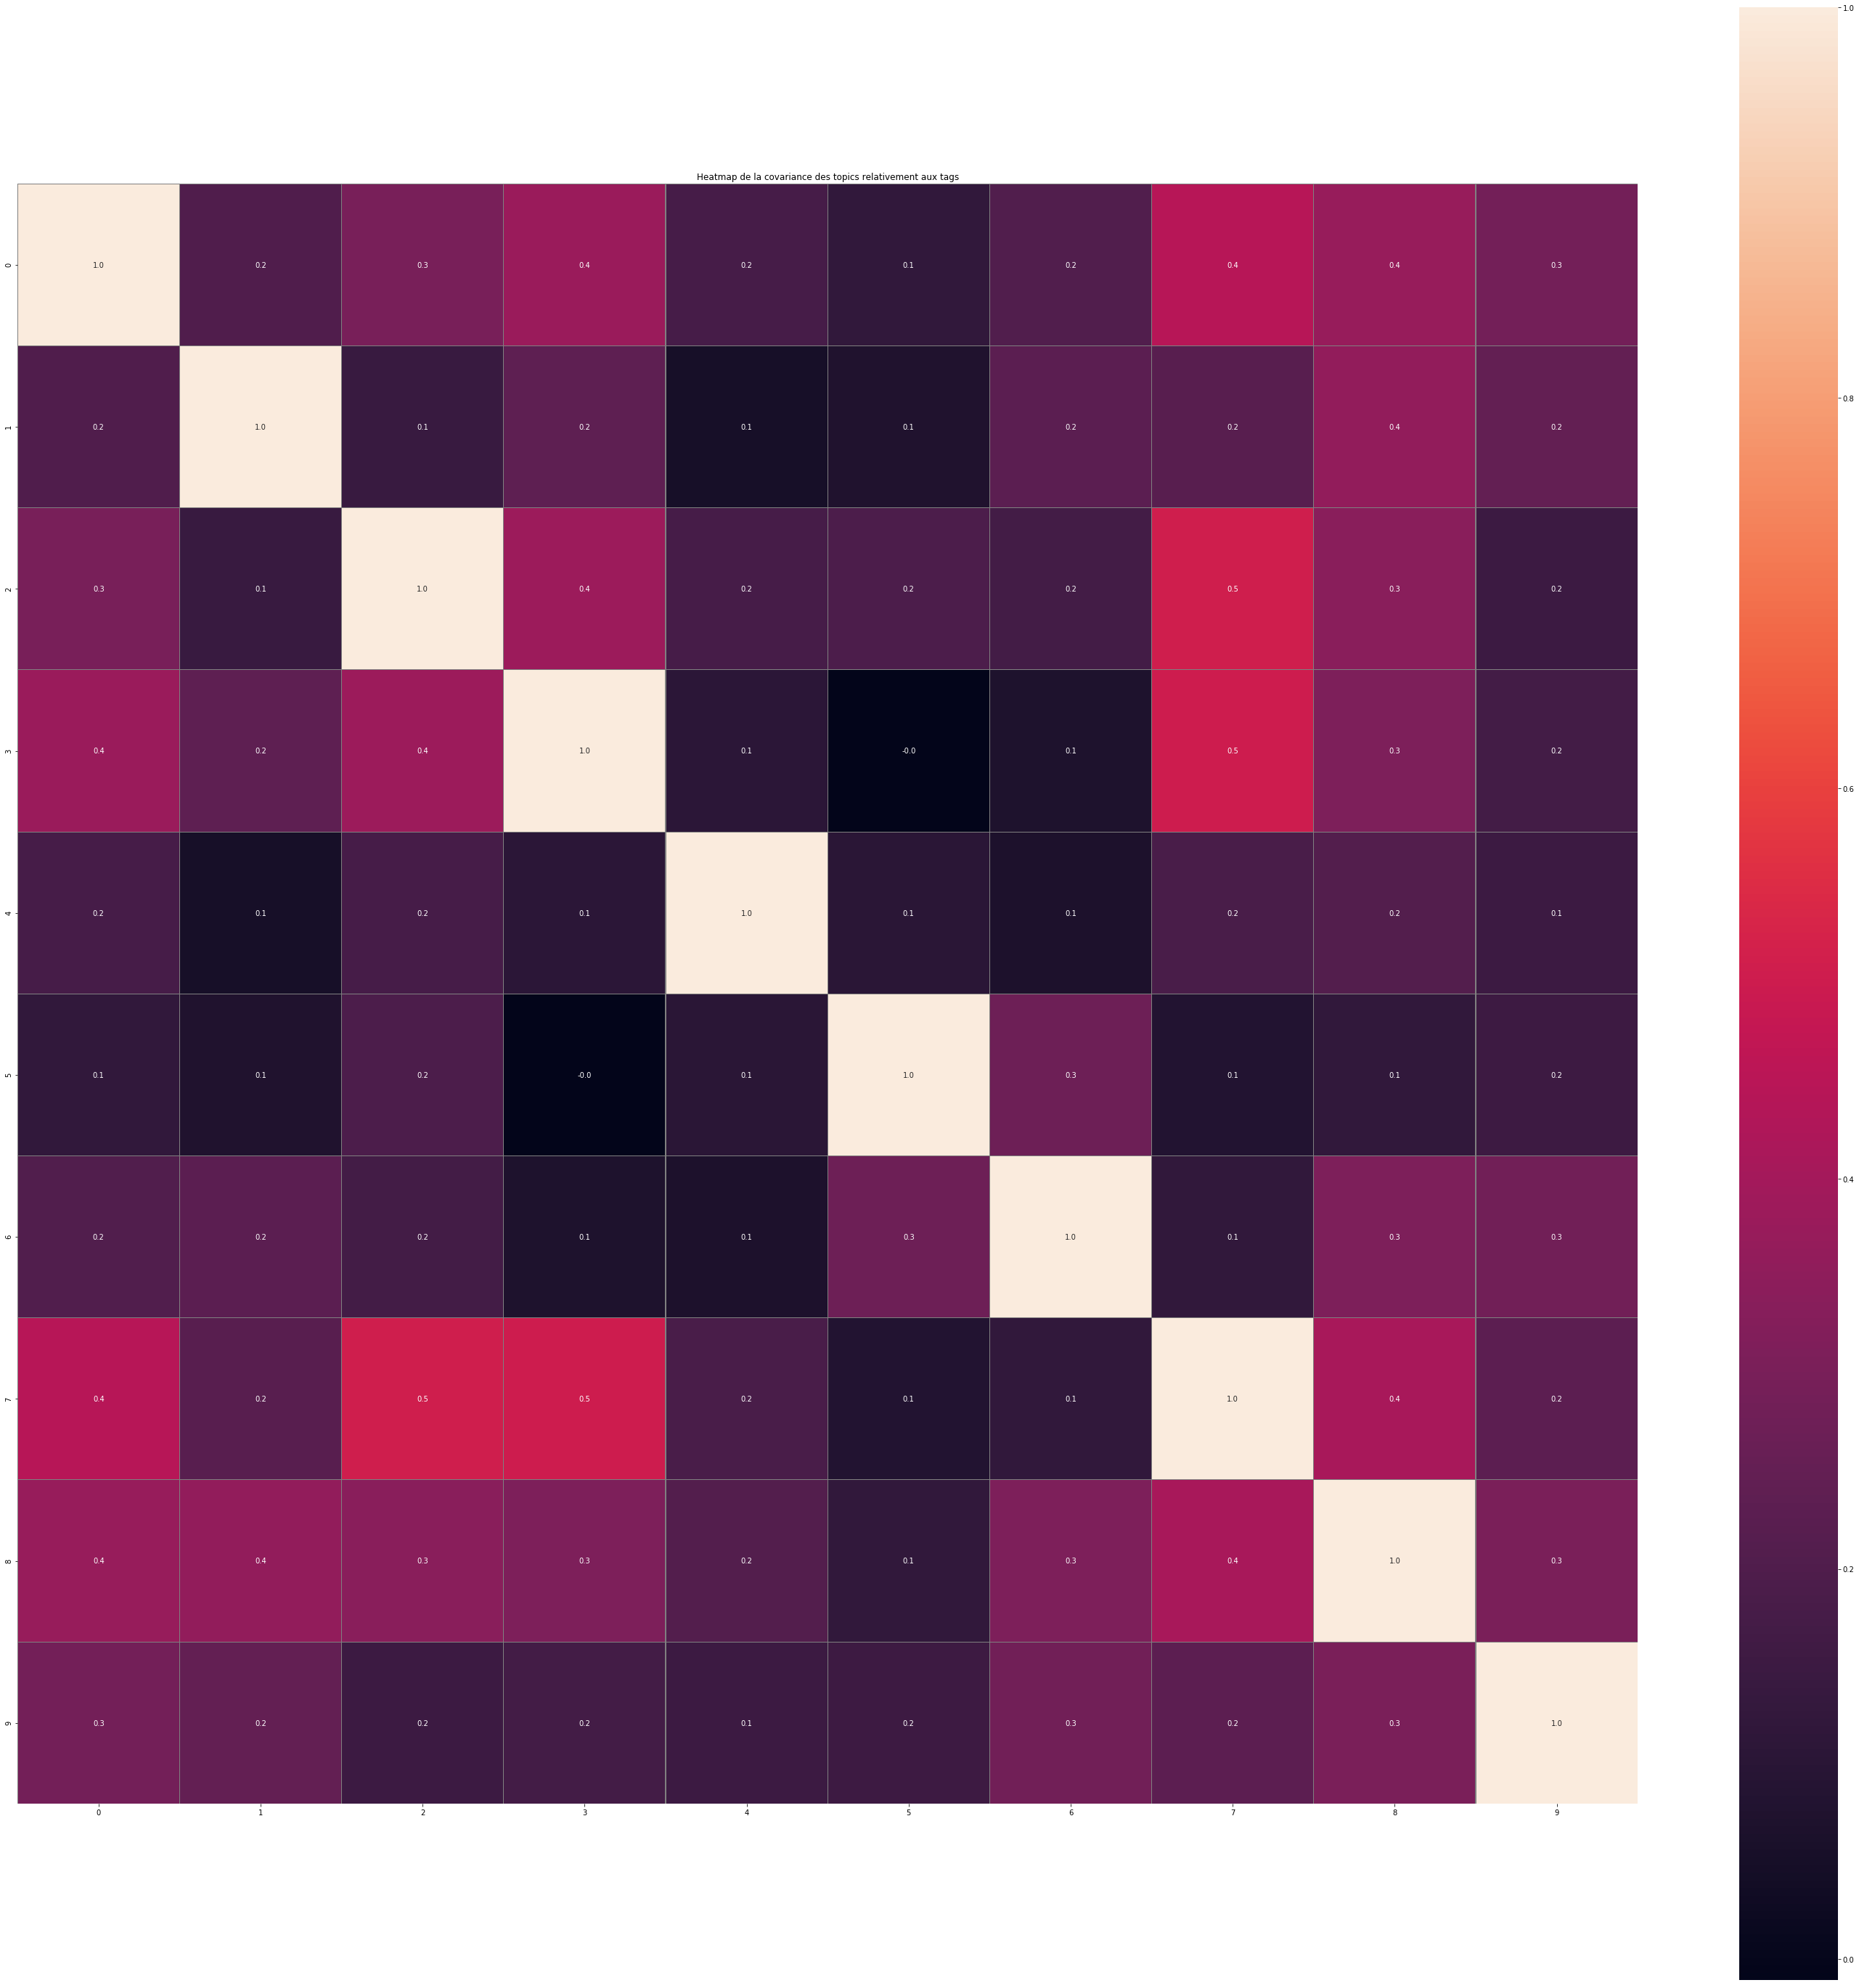

In [43]:
plt.figure(figsize=(50, 50))
sns.heatmap(df_corr,linecolor='grey' ,annot=True, linewidth=.1, fmt='.1f',square=True, cbar=True)
plt.title('Heatmap de la covariance des topics relativement aux tags')
plt.show()

<p>
        **<font color='#D2691E'size="4">VII) Topics management</font>**
</p>

In [44]:
THRESHOLD = 0.05
#THRESHOLD = 0.1

In [45]:
#We now want to build some dictionnaries that will map topics to the tags or words that have a strong weight (>= THRESHOLD): 
dict_topics_tags = {}
dict_topics_words = {}

for topic in L_topics:
    L_heavy_tags = list(df_tags_topics[df_tags_topics[topic]>=THRESHOLD].index)
    dict_topics_tags[topic] = L_heavy_tags
    
    L_heavy_words = list(df_words_topics[df_words_topics[topic]>=THRESHOLD].index)
    dict_topics_words[topic] = L_heavy_words

In [46]:
dict_topics_tags[0]

['c',
 'languageagnostic',
 'rubyonrails',
 'optimization',
 'datastructures',
 'functionalprogramming',
 'databasedesign',
 'objectivec',
 'cocoa',
 'opengl',
 'glossary',
 'math',
 'collections',
 'graphics',
 'indexing',
 'compilerconstruction',
 'sorting',
 'soap',
 'https',
 'ios',
 'fulltextsearch',
 'xhtml',
 'namespaces',
 'xsd',
 'fogbugz',
 'lambda',
 'interop',
 'passwords',
 'recursion',
 'algorithm',
 'api',
 'arrays',
 'iphone',
 'memory',
 'openid',
 'oracle',
 'pdf',
 'perl',
 'php',
 'python',
 'ruby',
 'session',
 'ssl',
 'tags',
 'ubuntu']

In [47]:
dict_topics_words[0]

['100',
 '32',
 'ability',
 'account',
 'algorithm',
 'amount',
 'anyway',
 'api',
 'appear',
 'array',
 'arrays',
 'article',
 'assume',
 'aware',
 'away',
 'bad',
 'bar',
 'blog',
 'book',
 'box',
 'building',
 'certain',
 'choose',
 'collection',
 'comment',
 'comments',
 'compare',
 'concept',
 'condition',
 'cost',
 'count',
 'def',
 'detail',
 'duplicate',
 'element',
 'equivalent',
 'exit',
 'explain',
 'filter',
 'flag',
 'foreach',
 'functionality',
 'graph',
 'helpful',
 'high',
 'hold',
 'hop',
 'icon',
 'implementation',
 'increase',
 'index',
 'integrate',
 'interested',
 'iphone',
 'items',
 'job',
 'learning',
 'love',
 'low',
 'maintain',
 'mark',
 'matter',
 'memory',
 'menu',
 'monitor',
 'nested',
 'next',
 'nodes',
 'none',
 'notice',
 'number',
 'objects',
 'online',
 'onto',
 'openid',
 'operator',
 'option',
 'oracle',
 'order',
 'others',
 'pdf',
 'perl',
 'php',
 'possibly',
 'post',
 'pre',
 'print',
 'programming',
 'provider',
 'python',
 'quick',
 'rails',


<p>
        **<font color='#D2691E'size="4">VIII) LDA main topics</font>**
</p>

In [48]:
df_corpus_topics.drop('corpus', axis=1, inplace=True)

In [49]:
df_train = pd.merge(df_train,df_corpus_topics,how='left',on='id')
df_train.head()

,id,Text,tag_list,corpus,text_len,unique_text_len,n_tags,tags_matching,n_tags_matching,matching_score,...,1,2,3,4,5,6,7,8,9,main_topic
0,1,percentage width child element in absolutely p...,"[html, css, internetexplorer7]",percentage width child element absolutely posi...,44,23,3,{css},1,0.333333,...,0.003125,0.003125,0.003125,0.971874,0.003125,0.003125,0.003125,0.003125,0.003125,4
1,2,how do i calculate someone age in csharp given...,"[net, csharp, datetime]",calculate age csharp datetime represent person...,9,7,3,"{csharp, datetime}",2,0.666667,...,0.012500,0.260677,0.012501,0.012500,0.012500,0.012501,0.639313,0.012507,0.012500,7
2,3,calculate relative time in csharp given a spec...,"[datetime, csharp]",calculate relative time csharp datetime value ...,16,12,2,"{csharp, datetime}",2,1.000000,...,0.007693,0.007694,0.007693,0.007693,0.007693,0.522774,0.415682,0.007693,0.007693,6
3,5,difference between mathfloor and mathtruncate ...,"[net, math]",msdnmicrosoftcom enus library msdnmicrosoftcom...,7,4,2,{net},1,0.500000,...,0.012502,0.887492,0.012500,0.012500,0.012501,0.012501,0.012500,0.012501,0.012503,2
4,6,filling a dataset or datatable from a linq que...,"[webservices, net35, linq, csharp]",fill dataset datatable linq query set expose l...,62,31,4,{linq},1,0.250000,...,0.002128,0.104481,0.659468,0.002128,0.002128,0.110944,0.112339,0.002128,0.002128,3


In [50]:
df_train['lda_tags'] = df_train['main_topic'].apply(lambda x : dict_topics_tags[x])
df_train['lda_words'] = df_train['main_topic'].apply(lambda x : dict_topics_words[x])
df_train.head()

,id,Text,tag_list,corpus,text_len,unique_text_len,n_tags,tags_matching,n_tags_matching,matching_score,...,3,4,5,6,7,8,9,main_topic,lda_tags,lda_words
0,1,percentage width child element in absolutely p...,"[html, css, internetexplorer7]",percentage width child element absolutely posi...,44,23,3,{css},1,0.333333,...,0.003125,0.971874,0.003125,0.003125,0.003125,0.003125,0.003125,4,"[languageagnostic, macos, userinterface, aspne...","[10, 100, 12, 2007, accomplish, achieve, actio..."
1,2,how do i calculate someone age in csharp given...,"[net, csharp, datetime]",calculate age csharp datetime represent person...,9,7,3,"{csharp, datetime}",2,0.666667,...,0.012501,0.012500,0.012500,0.012501,0.639313,0.012507,0.012500,7,"[sqlserver, c++, c, languageagnostic, webservi...","[10, 100, 11, 12, 15, 30, 50, accept, access, ..."
2,3,calculate relative time in csharp given a spec...,"[datetime, csharp]",calculate relative time csharp datetime value ...,16,12,2,"{csharp, datetime}",2,1.000000,...,0.007693,0.007693,0.007693,0.522774,0.415682,0.007693,0.007693,6,"[sqlserver, c++, visualstudio, c, languageagno...","[100, 15, 2003, 2007, 2008, 30, 32, 64bit, acc..."
3,5,difference between mathfloor and mathtruncate ...,"[net, math]",msdnmicrosoftcom enus library msdnmicrosoftcom...,7,4,2,{net},1,0.500000,...,0.012500,0.012500,0.012501,0.012501,0.012500,0.012501,0.012503,2,"[c++, visualstudio, c, languageagnostic, unitt...","[12, ability, abstract, accept, access, accomp..."
4,6,filling a dataset or datatable from a linq que...,"[webservices, net35, linq, csharp]",fill dataset datatable linq query set expose l...,62,31,4,{linq},1,0.250000,...,0.659468,0.002128,0.002128,0.110944,0.112339,0.002128,0.002128,3,"[sqlserver, languageagnostic, unittesting, asp...","[10, 11, 12, 15, 2000, 2005, 2008, accept, acc..."


<p>
        **<font color='#D2691E'size="4">IX) Word2Vec model training on the corpus of messages</font>**
</p>

In [51]:
df_train.head()

,id,Text,tag_list,corpus,text_len,unique_text_len,n_tags,tags_matching,n_tags_matching,matching_score,...,3,4,5,6,7,8,9,main_topic,lda_tags,lda_words
0,1,percentage width child element in absolutely p...,"[html, css, internetexplorer7]",percentage width child element absolutely posi...,44,23,3,{css},1,0.333333,...,0.003125,0.971874,0.003125,0.003125,0.003125,0.003125,0.003125,4,"[languageagnostic, macos, userinterface, aspne...","[10, 100, 12, 2007, accomplish, achieve, actio..."
1,2,how do i calculate someone age in csharp given...,"[net, csharp, datetime]",calculate age csharp datetime represent person...,9,7,3,"{csharp, datetime}",2,0.666667,...,0.012501,0.012500,0.012500,0.012501,0.639313,0.012507,0.012500,7,"[sqlserver, c++, c, languageagnostic, webservi...","[10, 100, 11, 12, 15, 30, 50, accept, access, ..."
2,3,calculate relative time in csharp given a spec...,"[datetime, csharp]",calculate relative time csharp datetime value ...,16,12,2,"{csharp, datetime}",2,1.000000,...,0.007693,0.007693,0.007693,0.522774,0.415682,0.007693,0.007693,6,"[sqlserver, c++, visualstudio, c, languageagno...","[100, 15, 2003, 2007, 2008, 30, 32, 64bit, acc..."
3,5,difference between mathfloor and mathtruncate ...,"[net, math]",msdnmicrosoftcom enus library msdnmicrosoftcom...,7,4,2,{net},1,0.500000,...,0.012500,0.012500,0.012501,0.012501,0.012500,0.012501,0.012503,2,"[c++, visualstudio, c, languageagnostic, unitt...","[12, ability, abstract, accept, access, accomp..."
4,6,filling a dataset or datatable from a linq que...,"[webservices, net35, linq, csharp]",fill dataset datatable linq query set expose l...,62,31,4,{linq},1,0.250000,...,0.659468,0.002128,0.002128,0.110944,0.112339,0.002128,0.002128,3,"[sqlserver, languageagnostic, unittesting, asp...","[10, 11, 12, 15, 2000, 2005, 2008, accept, acc..."


In [52]:
from gensim.models import word2vec
from nltk import word_tokenize

# tokenize sentences in corpus
corpus = df_train['corpus'].copy()
tokenized_corpus = corpus.apply(word_tokenize)


# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size,
                              window=window_context, min_count=min_word_count,
                              sample=sample, iter=100,
                              workers=6)

c:\python\python36\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [53]:
vectors = w2v_model.wv
pd.DataFrame(vectors['database','sql'])

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.216655,-0.022946,2.157869,0.764139,-5.682739,-2.018209,2.667108,1.713634,-1.539362,1.370862,...,0.943978,-1.405759,-2.328799,1.687788,-1.630749,-1.018529,-0.226161,-0.690425,0.828350,2.928697
1,1.322660,1.899851,1.942076,-0.622953,-4.477307,-2.001886,0.011321,0.404325,2.158091,-0.442678,...,2.191518,1.447940,-1.412553,0.617095,-1.579717,5.011451,-4.422907,0.934359,-1.661627,4.059946


In [54]:
print(vectors.similarity('database', 'sql'))

0.36680198275646314


In [55]:
L_tags_word2vec = [tag for tag in L_frequent_tags if tag in vectors]

In [56]:
L_missing_tags_word2vec = []
for word in L_frequent_tags:
    if not word in L_tags_word2vec:
        L_missing_tags_word2vec.append(word)
L_missing_tags_word2vec[0:10]

['macos',
 'userinterface',
 'sqlserver2005',
 'visualstudio2008',
 'rubyonrails',
 'net35',
 'webapplications',
 'designpatterns',
 'actionscript3',
 'visualstudio2005']

In [57]:
L_word2vec_words = [word for word in vectors.vocab.keys()]
L_word2vec_words[0:10]

['percentage',
 'width',
 'child',
 'element',
 'absolutely',
 'position',
 'parent',
 'internet',
 'explorer',
 '7']

<p>
        **<font color='#D2691E'size="4">X) Building the Word2Vec word/tags similarities matrices</font>**
</p>

In [58]:
df_word2vec_words_coordinates = pd.DataFrame(columns = [i for i in range(0,100)])
for word in L_word2vec_words:
    df_word_coordinates = pd.DataFrame(vectors[word]).T
    df_word_coordinates.index = [word]
    df_word2vec_words_coordinates = df_word2vec_words_coordinates.append(df_word_coordinates)
df_word2vec_words_coordinates.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
percentage,-3.505091,-1.668856,-0.865202,1.418971,-1.056985,1.229508,0.719332,-0.749155,2.079641,-0.492050,...,0.650033,-1.828801,-2.091505,1.069836,0.237657,-3.933155,1.757577,-3.941599,1.773818,-0.218896
width,2.094468,-0.003639,2.950352,-2.524790,-5.326464,2.259780,-2.719476,3.697120,0.121007,0.355184,...,4.977355,-5.138704,-2.302178,-0.001615,-1.639207,-4.845417,-1.081264,-3.742113,5.355059,-2.446515
child,-3.551270,-8.199946,-0.334776,-0.651751,-0.681582,0.605892,-5.409343,0.744445,-1.336352,-3.723303,...,-5.202053,-3.476259,0.894778,-0.057422,-2.184343,-0.813416,1.526862,1.783692,2.941630,-1.554858
element,2.782551,-0.565738,3.808624,0.482018,1.612508,-0.388669,3.026443,1.421463,2.104777,-0.238849,...,0.316596,1.712672,1.369116,-1.632708,-4.400882,-0.223445,2.559914,-0.833203,2.551156,0.455607
absolutely,-1.889867,-2.504379,1.793189,0.872845,-1.666114,-0.451789,1.773435,-1.899011,-0.137872,3.265435,...,0.501689,-0.236239,-0.625202,1.075657,0.568408,-1.144394,-0.771875,-0.191974,-1.476608,-1.253821


In [59]:
df_word2vec_tags_coordinates = df_word2vec_words_coordinates.loc[L_tags_word2vec]
df_word2vec_tags_coordinates.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
csharp,0.363790,0.737597,-1.753533,3.199753,-0.451773,-1.368086,0.841610,-2.182649,-1.467913,-0.318478,...,-0.962458,2.013210,0.836810,-1.748806,1.016730,-2.745765,-0.488953,-0.608077,-1.473478,2.985574
net,-0.596157,1.662553,0.749938,-0.351424,-1.942635,-3.034744,-0.417543,-0.692850,2.050537,1.111196,...,0.046854,2.451114,-2.891636,0.383124,2.385710,0.272350,-0.529182,-2.332933,-0.753644,0.995207
aspnet,-3.654664,0.869529,0.646879,-3.877734,-0.706988,3.025608,2.428627,-2.614295,-0.110005,-0.821502,...,-1.470234,4.510159,-0.735085,-0.037637,0.835435,2.833850,-0.755956,-3.818169,1.160510,-0.144611
java,-1.542333,-1.415920,0.446794,0.749818,-1.361521,-1.079782,2.295124,0.413606,-2.418814,-0.629969,...,0.610399,3.493386,-0.727009,-0.117792,0.261518,2.648227,0.114626,-2.875129,1.679889,3.665534
sqlserver,-0.676282,1.072233,-0.188786,-0.658214,-1.264354,-0.816785,0.146574,1.663950,1.188694,1.727369,...,-0.179331,1.442233,1.444468,-0.424872,1.930336,1.315840,0.199868,2.581620,-2.368948,2.465410


In [60]:
#With this two dataframes, we can compute the similarities between tags and words (with tags) in the topic's space:
X_tags_word2vec = df_word2vec_tags_coordinates.values
X_words_word2vec = df_word2vec_words_coordinates.values

df_word2vec_tags_similarity = pd.DataFrame(cosine_similarity(X_tags_word2vec),\
                                           columns=df_word2vec_tags_coordinates.index,\
                                           index=df_word2vec_tags_coordinates.index)

df_word2vec_words_similarity = pd.DataFrame(cosine_similarity(X_words_word2vec),\
                                            columns=df_word2vec_words_coordinates.index,\
                                            index=df_word2vec_words_coordinates.index)

#We will now be able to use this 2 news matrices of similarities with our function which finds the neighbors of each word, based
#on the cosine similarity

In [61]:
#Gensim implements methods that can search most similar words associated to lists terms BUT the advantage is here that we
#built a space restrained on the tags, whereas the gensim's space contains all the words of the word2vec model
#We can now find neighbors of tags that are uniquely tags (instead of tags + words)
# view similar words based on gensim's model : 
SIMILAR_WORDS = 10
similar_tags = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term ] , topn=SIMILAR_WORDS)]
                  for search_term in L_tags_word2vec}

df_word2vec_gensim_tags_similarity = pd.DataFrame(similar_tags)
df_word2vec_gensim_tags_similarity

,64bit,adobe,adonet,agile,air,ajax,algorithm,apache,api,architecture,...,windowsserver2003,windowsxp,winforms,workflow,wpf,xcode,xhtml,xml,xsd,xslt
0,32bit,air,parentid,scrum,swf,page,algorithms,mod,docsoraclecom,agile,...,blogger,wamp,azman,crm,xaml,qmake,doctype,document,foreign,xml
1,x64,applescript,con,methodology,actionscript,updatepanel,patching,ssi,javase,separation,...,wwwhanselmancom,virtualhost,forms,activity,prism,31,dtd,infopath,datatype,transform
2,continue,winhelp,mvcc,wall,adobe,postback,optimize,sep,nt4,refactorings,...,painful,proceed,impersonation,blogs,viewport3d,addins,w3c,xslt,dataset,webbrowser
3,planning,photoshop,grid,collaboration,sys,consistent,directed,pop3,nullpointerexception,logic,...,year,undefined,picturebox,indication,picturebox,cocoa,strict,biztalk,chain,ltcategory
4,ganymede,anchor,datatable,story,intercept,callback,brain,228,ref,interest,...,wwwmicrosoftcom,malloc,treeview,wf,defaultview,compile,langhtml,applescript,excel,hql
5,dav,xtype,pros,design,apache,serverside,versionb,tred,illegalargumentexception,design,...,noscript,esx,app,flags,resizable,unittesting,lthtml,serialize,section,uml
6,distro,cairngorm,foreign,coworker,stdout,prototype,systemoutprintlninvalid,openbsd,ltobject,patterns,...,facility,regularly,intptr,decide,datarowview,exe,ltbody,substitute,vb,stylesheet
7,favourite,actionscript,retrieve,daily,flex,weblogsaspnet,efficiency,shtml,bless,frustration,...,archive,noclassdeffounderror,application,alongside,gantt,sys,wwww3org,computing,essentially,produce
8,tradeoff,filesystem,subsonic,architecture,xdebug,response,transpose,air,usb,frontend,...,xtunit,mix,hresult,running,blend,paradigm,paragraph,interesting,confirm,subsonic
9,2006,flashplayer,consensus,picasa,tred,ajaxcontroltoolkit,insertion,thu,inspect,refactoring,...,scopeguard,vmware,folders,normalizing,ui,bundle,1999,expose,followup,populate


In [62]:
#Let's check if the result of our function is the same than the gensim's one : 

In [63]:
#Gensim's result : 
pd.DataFrame({search_term: [item[0] for item in w2v_model.wv.most_similar([search_term ] , topn=SIMILAR_WORDS)]
                  for search_term in ['c', 'file','database','sql','python','javascript','zip','mac','cpu']})

,c,cpu,database,file,javascript,mac,python,sql,zip
0,unresolved,usage,relational,project,prototype,objectivec,sip,sqlserver,unzip
1,referencec,profiling,deletes,rename,jquery,developerapplecom,lxml,2000,compression
2,desktop,usual,instance,quit,ltscript,ptrace,django,database,compress
3,linkage,com+,dba,dot,intelligence,leopard,relnoreferrerpython,relnoreferrersql,gzip
4,isight,water,sql,subdirectory,exploit,opensource,indexhtml,logically,transpose
5,definition,multicore,persistence,cr,animate,textwrangler,distutils,retrieve,skip
6,marshalling,maximum,triggers,el,subscribe,monitor,packaging,failover,extreme
7,chess,sleep,maintenance,disk,xdebug,linux,based,checked,divisor
8,reserved,dosomething,crud,doubleclick,logo,crossplatform,ctypes,stag,config
9,b,average,express,readline,proven,osx,next,pivot,ironpython


In [64]:
#Our custom function's result : 
pd.DataFrame(find_similar_words(df_word2vec_words_similarity,['c', 'file','database','sql','python','javascript','zip','mac','cpu'],SIMILAR_WORDS))

,c,cpu,database,file,javascript,mac,python,sql,zip
0,unresolved,usage,relational,project,prototype,objectivec,sip,sqlserver,unzip
1,referencec,profiling,deletes,rename,jquery,developerapplecom,lxml,2000,compression
2,desktop,usual,instance,quit,ltscript,ptrace,django,database,compress
3,linkage,com+,dba,dot,intelligence,leopard,relnoreferrerpython,relnoreferrersql,gzip
4,isight,water,sql,subdirectory,exploit,opensource,indexhtml,logically,transpose
5,definition,multicore,persistence,cr,animate,textwrangler,distutils,retrieve,skip
6,marshalling,maximum,triggers,el,subscribe,monitor,packaging,failover,extreme
7,chess,sleep,maintenance,disk,xdebug,linux,based,checked,divisor
8,reserved,dosomething,crud,doubleclick,logo,crossplatform,ctypes,stag,config
9,b,average,express,readline,proven,osx,next,pivot,ironpython


In [65]:
pd.DataFrame(find_similar_words(df_word2vec_tags_similarity,['c','file','database','sql','python','javascript'],10))

,c,database,file,javascript,python,sql
0,cocoa,sql,tortoisesvn,jquery,django,sqlserver
1,linker,triggers,process,dom,postgresql,database
2,csharp,sqlite,interop,css,ubuntu,adonet
3,winapi,linqtosql,registry,firefox,scripting,ssis
4,objectivec,oracle,ftp,browser,perl,tsql
5,delphi,sqlserver,exception,ajax,operatingsystem,csharp
6,postgresql,orm,io,aspnet,linux,vbnet
7,interop,postgresql,nant,multithreading,tdd,datetime
8,windows,tsql,unix,crossplatform,linq,enums
9,swing,xsd,installer,regex,apache,windowsserver2003


<p>
        **<font color='#D2691E'size="4">XI) Word2Vec model training on the pure corpus of tag lists</font>**
</p>

In [66]:
tags_corpus = df_train[['tag_list']].copy()
tags_corpus.head()

,tag_list
0,"[html, css, internetexplorer7]"
1,"[net, csharp, datetime]"
2,"[datetime, csharp]"
3,"[net, math]"
4,"[webservices, net35, linq, csharp]"


In [67]:
dict_tags_replacement = pickle.load(open(pickles_path+"dict_tags_replacement.p", "rb" ))
reverse_dict_tags_replacement = {v: k for k, v in dict_tags_replacement.items()}
reverse_dict_tags_replacement['csharp']

'c#'

In [68]:
tags_corpus['raw_tag_list'] = tags_corpus['tag_list'].apply(lambda x : [reverse_dict_tags_replacement[tag] for tag in x])
tags_corpus.head()

,tag_list,raw_tag_list
0,"[html, css, internetexplorer7]","[html, css, internet-explorer-7]"
1,"[net, csharp, datetime]","[.net, c#, datetime]"
2,"[datetime, csharp]","[datetime, c#]"
3,"[net, math]","[.net, math]"
4,"[webservices, net35, linq, csharp]","[web-services, .net-3.5, linq, c#]"


In [69]:
for col in ['raw_tag_list','tag_list']:
    tags_corpus[col] = tags_corpus[col].astype(str)
tags_corpus['tag_list'] = tags_corpus['tag_list']+tags_corpus['raw_tag_list']
tags_corpus.drop('raw_tag_list', axis=1, inplace=True)
tags_corpus.head()

,tag_list
0,"['html', 'css', 'internetexplorer7']['html', '..."
1,"['net', 'csharp', 'datetime']['.net', 'c#', 'd..."
2,"['datetime', 'csharp']['datetime', 'c#']"
3,"['net', 'math']['.net', 'math']"
4,"['webservices', 'net35', 'linq', 'csharp']['we..."


In [70]:
dict_replacement = {'[-\. ]':' ','[cC] {0,1}#':'csharp','[\[\]\',]':' ',' +':' '}
for pattern, replacement in dict_replacement.items():
    tags_corpus['tag_list'] = tags_corpus['tag_list'].str.replace(pattern,replacement)
tags_corpus.head()

,tag_list
0,html css internetexplorer7 html css internet ...
1,net csharp datetime net csharp datetime
2,datetime csharp datetime csharp
3,net math net math
4,webservices net35 linq csharp web services ne...


In [71]:
tags_corpus['tag_list'][1]

' net csharp datetime net csharp datetime '

In [72]:
tags_corpus['tag_list'] = tags_corpus['tag_list'].apply(word_tokenize)
tokenized_tags_corpus = list(tags_corpus['tag_list'])

In [73]:
# Set values for various parameters
feature_size = 50    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_pure_tags_model = word2vec.Word2Vec(tokenized_tags_corpus, size=feature_size,
                              window=window_context, min_count=min_word_count,
                              sample=sample, iter=100,
                              workers=6)
pure_tags_vectors = w2v_pure_tags_model.wv

In [74]:
L_word2vec_pure_tags_words = [word for word in pure_tags_vectors.vocab.keys()]

df_word2vec_pure_tags_coordinates = pd.DataFrame(columns = [i for i in range(0,50)])
for word in L_word2vec_pure_tags_words:
    df_word_coordinates = pd.DataFrame(pure_tags_vectors[word]).T
    df_word_coordinates.index = [word]
    df_word2vec_pure_tags_coordinates = df_word2vec_pure_tags_coordinates.append(df_word_coordinates)
df_word2vec_pure_tags_coordinates.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
html,0.457527,-0.407762,-0.536384,-1.155188,-0.113069,-0.122497,-0.131197,-1.675252,-0.733387,0.790840,...,-0.207381,0.827383,-1.295125,0.772305,0.930346,-0.356939,-0.326056,-0.068752,1.595134,-0.997035
css,0.195757,-0.309207,0.220480,-0.822204,-0.328056,-0.114034,-0.019571,-1.467007,-1.925317,-0.368074,...,0.369758,2.209853,-0.807992,0.694629,1.575415,0.468378,-0.294231,-0.501940,2.231404,-1.133159
internetexplorer7,0.781617,-0.740572,-0.136721,-0.290954,-0.163259,-0.203626,-0.240662,-0.711000,-0.262836,-0.871809,...,0.930082,1.045646,-0.448415,0.480745,1.369489,0.368068,-0.086077,0.616160,0.679735,-0.633909
internet,2.841263,-1.999540,0.469124,-0.177016,-1.561352,0.417035,-0.298863,-1.814143,-1.332811,-2.258582,...,2.171788,2.454307,-1.544150,0.860501,4.109209,-0.340262,1.174070,-0.443907,0.990943,-0.612198
explorer,2.468282,-1.974432,0.358482,-0.188445,-1.421179,0.168793,-0.499013,-2.109409,-1.332636,-2.167648,...,2.028358,2.676109,-1.397215,1.418401,3.555992,-0.340854,1.472704,-0.127626,1.081807,-0.580318


In [75]:
X_pure_tags_word2vec = df_word2vec_pure_tags_coordinates.values

df_word2vec_pure_tags_similarity = pd.DataFrame(cosine_similarity(X_pure_tags_word2vec),\
                                           columns=df_word2vec_pure_tags_coordinates.index,\
                                           index=df_word2vec_pure_tags_coordinates.index)
df_word2vec_pure_tags_similarity.head()

,html,css,internetexplorer7,internet,explorer,7,net,csharp,datetime,math,...,projectmanagement,project,management,webforms,django,ssis,gcc,googlechrome,google,chrome
html,1.000000,0.741098,0.615900,0.493529,0.515039,0.635353,-0.111998,-0.143547,0.195968,0.025284,...,0.040542,0.047211,0.055406,0.343377,0.148714,-0.094453,-0.211690,0.247608,0.282790,0.283165
css,0.741098,1.000000,0.559503,0.563135,0.570470,0.591455,0.072208,-0.021823,0.041475,-0.113840,...,-0.086143,-0.084406,-0.099899,0.272566,0.050286,-0.057913,0.087301,0.436724,0.452773,0.466682
internetexplorer7,0.615900,0.559503,1.000000,0.874254,0.883353,0.992738,-0.148773,-0.136086,0.031460,-0.166024,...,0.017302,0.029111,0.013316,0.228156,0.071034,0.112888,-0.006886,0.341716,0.347861,0.396412
internet,0.493529,0.563135,0.874254,1.000000,0.982157,0.858922,-0.060190,-0.119517,0.040560,-0.214676,...,-0.070597,-0.060014,-0.079873,0.313417,0.001153,0.095608,0.091266,0.356382,0.341325,0.402606
explorer,0.515039,0.570470,0.883353,0.982157,1.000000,0.867614,-0.103287,-0.161912,0.049809,-0.199564,...,-0.022850,-0.011128,-0.033636,0.307883,0.002399,0.096743,0.073662,0.348196,0.334639,0.399083


In [76]:
pd.DataFrame(find_similar_words(df_word2vec_pure_tags_similarity,['2008', 'html','database','sql','internet','google','visualstudio'],10))

,2008,database,google,html,internet,sql,visualstudio
0,visualstudio2008,databasedesign,googlechrome,css,explorer,storedprocedures,2008
1,visualstudio,sql,chrome,xhtml,internetexplorer,stored,visualstudio2005
2,visualstudio2005,postgresql,windowsinstaller,7,internetexplorer7,sqlserver2005,2005
3,tfs,triggers,browser,javascript,7,procedures,visualstudio2008
4,net35,mysql,crossbrowser,internetexplorer7,internetexplorer6,database,visualc++
5,visual,oracle,css,jquery,6,server,linker
6,5,stored,cross,tags,javascript,triggers,visual
7,crystal,indexing,fonts,regex,css,tsql,tfs
8,studio,storedprocedures,firefox,explorer,jquery,reporting,debugging
9,crystalreports,versioncontrol,xhtml,internet,crossbrowser,reportingservices,unit


<p>
        **<font color='#D2691E'size="4">XII) Generating tags</font>**
</p>

In [77]:
def generate_tags(myText,
                  lda_word_sim_matrix,
                  lda_tag_sim_matrix,
                  w2v_word_sim_matrix,
                  w2v_tag_sim_matrix,
                  w2v_pure_tag_sim_matrix,
                  existing_tags,
                  NEIGHBORS,
                  recommendation_filter,
                  THRESHOLD):
    
    """
    This function goal is to generate tags from words similarities matrices built with LDA and Wor2Vec models
    We initialize an empty list 'L_recommendation'
    for all word in a given text :
        - Neighbor selection : Each matrix allows to find N neighbors of the word
        - Each neighbor computed is added to a 'L_recommendation' each time it is encountered by the "Neighbor selection"
    We then use a first Counter in order to get each word occurences in 'L_recommendation'
    A second Counter is used on the similarity martix built with an embedding restricted on tags : its values are multiplied by 4
    The two Counters are merged and allows to dertermine the value occuences's quantile 'THRESHOLD'
    
    Finally the recommendation consists of : 
        - selecting the words with occurences > quantile[THRESHOLD]
        - proposing text words which are already tags
    
    PARAMETERS : 
    - 'lda_word_sim_matrix' : a matrix similarity between all words, built with LDA
    - 'lda_tag_sim_matrix' : a matrix similarity between all tags, built with LDA
    - 'w2v_word_sim_matrix' : a matrix similarity between all words, built with a word embedding on the corpus
    - 'w2v_tag_sim_matrix' : a matrix similarity between all tags, built with a word embedding on the corpus
    - 'w2v_pure_tag_sim_matrix' : a matrix similarity between all tags, built with a word embedding restricted on tags lists
    - 'existing_tags' : the existing tags of the stuty
    - 'NEIGHBORS' : the number of neighbors to look after in the matrices
    - 'recommendation_filter' : a filter of tags to use, since some of the "existing_tags" can be out of the train perimeter
    - 'THRESHOLD' 0 < [int] < 1 : The occurence threshold to use in terms of occurences's quantile
    """

    from collections import Counter
    import pandas as pd

    L_recommendation = []
    L_pure_tags_recommendation = []
    L_sim_matrices = [lda_word_sim_matrix,lda_tag_sim_matrix,w2v_word_sim_matrix,w2v_tag_sim_matrix,w2v_pure_tag_sim_matrix]
    L_labels = ['lda_word_sim_matrix','lda_tag_sim_matrix','w2v_word_sim_matrix','w2v_tag_sim_matrix','w2v_pure_tag_sim_matrix']

    corpus = myText.split(" ")
    matching_tags = set(corpus).intersection(set(existing_tags))
    for word in corpus:
        for sim_matrix,label in zip(L_sim_matrices,L_labels):
            if word in sim_matrix.index :
                matrix_recommendation = find_similar_words(sim_matrix,[word],NEIGHBORS)
                matrix_recommendation = matrix_recommendation[word]
                matrix_recommendation = list(set(matrix_recommendation).intersection(set(recommendation_filter)))
                if label != 'w2v_pure_tag_sim_matrix':
                    L_recommendation+= matrix_recommendation
                else:
                    L_pure_tags_recommendation+= matrix_recommendation
                    L_pure_tags_recommendation = sorted(L_pure_tags_recommendation)

            else:
                matrix_recommendation = []
                if label != 'w2v_pure_tag_sim_matrix':
                    L_recommendation+= matrix_recommendation
                else:
                    L_pure_tags_recommendation+= matrix_recommendation
                    L_pure_tags_recommendation = sorted(L_pure_tags_recommendation)

    all_models_counter = dict(Counter(L_recommendation))
    pure_tags_counter = dict(Counter(L_pure_tags_recommendation))
    df_all_models_counter = pd.DataFrame(all_models_counter,index=['occurences']).T
    df_pure_tags_counter = pd.DataFrame(pure_tags_counter,index=['occurences']).T
    df_pure_tags_counter['occurences'] = 4*df_pure_tags_counter['occurences']

    df_final_counter = df_all_models_counter.append(df_pure_tags_counter)
    df_final_counter = df_final_counter.groupby(df_final_counter.index).sum()
    df_final_counter.sort_values(by='occurences', ascending=False, inplace=True)

    quantiles = df_final_counter['occurences'].quantile(q=[THRESHOLD])
    quantiles = quantiles.to_dict()

    df_final_counter = df_final_counter[df_final_counter['occurences']>=quantiles[THRESHOLD]]
    L_final_recommendation = set(list(df_final_counter.index)+list(matching_tags))

    return(L_final_recommendation)

In [78]:
start_time = time.time()

df_train['recommendation'] = df_train.apply(lambda x : generate_tags(x['corpus'],
                                                                     df_lda_words_similarity,
                                                                     df_lda_tags_similarity,
                                                                     df_word2vec_words_similarity,
                                                                     df_word2vec_tags_similarity,
                                                                     df_word2vec_pure_tags_similarity,
                                                                     L_frequent_tags,
                                                                     5,
                                                                     x['lda_tags'],
                                                                     0.8),
                                            axis=1)


print("--- %s seconds ---" % (time.time() - start_time))
df_train['recommendation'][0:10]

--- 538.3855948448181 seconds ---


0    {internetexplorer7, html, internetexplorer, jq...
1    {datetime, tsql, csharp, net20, net, regex, date}
2    {crystalreports, datetime, net35, csharp, net2...
3                       {controls, net35, csharp, net}
4    {crystalreports, xsd, linq, string, performanc...
5    {collections, database, mysql, databinding, po...
6    {errorhandling, database, mysql, postgresql, a...
7    {actionscript3, crystalreports, memory, net35,...
8    {sqlserver, installation, sql, databasedesign,...
9    {c, cocoa, controls, types, compactframework, ...
Name: recommendation, dtype: object

<p>
        **<font color='#D2691E'size="4">XIII) CHECKS on the train perimeter</font>**
</p>

In [79]:
L_check_analysis = ['id','corpus','main_topic','text_len','tag_list','n_tags','tags_matching','matching_score','recommendation']

In [80]:
df_train[L_check_analysis].head()

,id,corpus,main_topic,text_len,tag_list,n_tags,tags_matching,matching_score,recommendation
0,1,percentage width child element absolutely posi...,4,44,"[html, css, internetexplorer7]",3,{css},0.333333,"{internetexplorer7, html, internetexplorer, jq..."
1,2,calculate age csharp datetime represent person...,7,9,"[net, csharp, datetime]",3,"{csharp, datetime}",0.666667,"{datetime, tsql, csharp, net20, net, regex, date}"
2,3,calculate relative time csharp datetime value ...,6,16,"[datetime, csharp]",2,"{csharp, datetime}",1.000000,"{crystalreports, datetime, net35, csharp, net2..."
3,5,msdnmicrosoftcom enus library msdnmicrosoftcom...,2,7,"[net, math]",2,{net},0.500000,"{controls, net35, csharp, net}"
4,6,fill dataset datatable linq query set expose l...,3,62,"[webservices, net35, linq, csharp]",4,{linq},0.250000,"{crystalreports, xsd, linq, string, performanc..."


In [81]:
df_train['n_tags_recommended'] = df_train.apply(lambda x : len(x['recommendation']),axis=1)
L_check_analysis.append('n_tags_recommended')
df_train[L_check_analysis].head()

,id,corpus,main_topic,text_len,tag_list,n_tags,tags_matching,matching_score,recommendation,n_tags_recommended
0,1,percentage width child element absolutely posi...,4,44,"[html, css, internetexplorer7]",3,{css},0.333333,"{internetexplorer7, html, internetexplorer, jq...",7
1,2,calculate age csharp datetime represent person...,7,9,"[net, csharp, datetime]",3,"{csharp, datetime}",0.666667,"{datetime, tsql, csharp, net20, net, regex, date}",7
2,3,calculate relative time csharp datetime value ...,6,16,"[datetime, csharp]",2,"{csharp, datetime}",1.000000,"{crystalreports, datetime, net35, csharp, net2...",6
3,5,msdnmicrosoftcom enus library msdnmicrosoftcom...,2,7,"[net, math]",2,{net},0.500000,"{controls, net35, csharp, net}",4
4,6,fill dataset datatable linq query set expose l...,3,62,"[webservices, net35, linq, csharp]",4,{linq},0.250000,"{crystalreports, xsd, linq, string, performanc...",10


In [82]:
df_train['matching_tags_train'] = df_train.apply(lambda x : set(x['recommendation']).intersection(set(x['tag_list'])), axis=1)
L_check_analysis.append('matching_tags_train')
df_train[L_check_analysis].head()

,id,corpus,main_topic,text_len,tag_list,n_tags,tags_matching,matching_score,recommendation,n_tags_recommended,matching_tags_train
0,1,percentage width child element absolutely posi...,4,44,"[html, css, internetexplorer7]",3,{css},0.333333,"{internetexplorer7, html, internetexplorer, jq...",7,"{internetexplorer7, html, css}"
1,2,calculate age csharp datetime represent person...,7,9,"[net, csharp, datetime]",3,"{csharp, datetime}",0.666667,"{datetime, tsql, csharp, net20, net, regex, date}",7,"{csharp, datetime, net}"
2,3,calculate relative time csharp datetime value ...,6,16,"[datetime, csharp]",2,"{csharp, datetime}",1.000000,"{crystalreports, datetime, net35, csharp, net2...",6,"{csharp, datetime}"
3,5,msdnmicrosoftcom enus library msdnmicrosoftcom...,2,7,"[net, math]",2,{net},0.500000,"{controls, net35, csharp, net}",4,{net}
4,6,fill dataset datatable linq query set expose l...,3,62,"[webservices, net35, linq, csharp]",4,{linq},0.250000,"{crystalreports, xsd, linq, string, performanc...",10,{linq}


In [83]:
df_train['matching_score_train'] = df_train.apply(lambda x : len(x['matching_tags_train'])/x['n_tags'], axis=1)
L_check_analysis.append('matching_score_train')
df_train[L_check_analysis].head()

,id,corpus,main_topic,text_len,tag_list,n_tags,tags_matching,matching_score,recommendation,n_tags_recommended,matching_tags_train,matching_score_train
0,1,percentage width child element absolutely posi...,4,44,"[html, css, internetexplorer7]",3,{css},0.333333,"{internetexplorer7, html, internetexplorer, jq...",7,"{internetexplorer7, html, css}",1.00
1,2,calculate age csharp datetime represent person...,7,9,"[net, csharp, datetime]",3,"{csharp, datetime}",0.666667,"{datetime, tsql, csharp, net20, net, regex, date}",7,"{csharp, datetime, net}",1.00
2,3,calculate relative time csharp datetime value ...,6,16,"[datetime, csharp]",2,"{csharp, datetime}",1.000000,"{crystalreports, datetime, net35, csharp, net2...",6,"{csharp, datetime}",1.00
3,5,msdnmicrosoftcom enus library msdnmicrosoftcom...,2,7,"[net, math]",2,{net},0.500000,"{controls, net35, csharp, net}",4,{net},0.50
4,6,fill dataset datatable linq query set expose l...,3,62,"[webservices, net35, linq, csharp]",4,{linq},0.250000,"{crystalreports, xsd, linq, string, performanc...",10,{linq},0.25


In [84]:
np.mean(df_train['n_tags_recommended'])

11.062452399086062

In [85]:
np.median(df_train['n_tags_recommended'])

10.0

In [86]:
np.mean(df_train['matching_score_train'])

0.6956037911483456

In [87]:
np.median(df_train['matching_score_train'])

1.0

In [88]:
np.mean(df_train['matching_score'])

0.5321697554370821

In [89]:
np.median(df_train['matching_score'])

0.5

In [90]:
df_train.columns

Index([                  'id',                 'Text',             'tag_list',
                     'corpus',             'text_len',      'unique_text_len',
                     'n_tags',        'tags_matching',      'n_tags_matching',
             'matching_score',                      0,                      1,
                            2,                      3,                      4,
                            5,                      6,                      7,
                            8,                      9,           'main_topic',
                   'lda_tags',            'lda_words',       'recommendation',
         'n_tags_recommended',  'matching_tags_train', 'matching_score_train'],
      dtype='object')

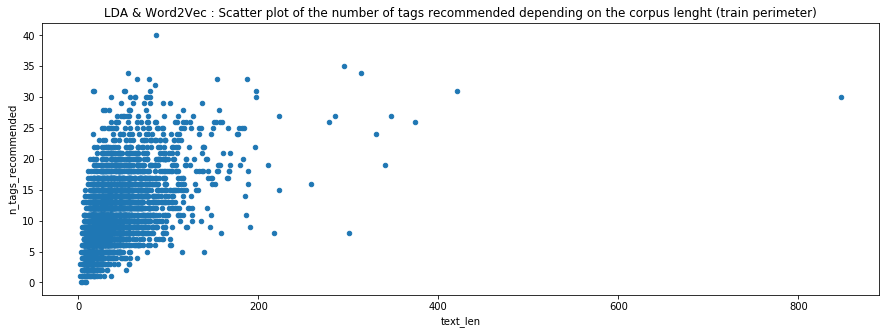

In [91]:
df_train.plot.scatter(x='text_len',
                     y='n_tags_recommended',
                     figsize=(15,5),
                     title = "LDA & Word2Vec : Scatter plot of the number of tags recommended depending on the corpus lenght (train perimeter)")

In [92]:
import seaborn as sns

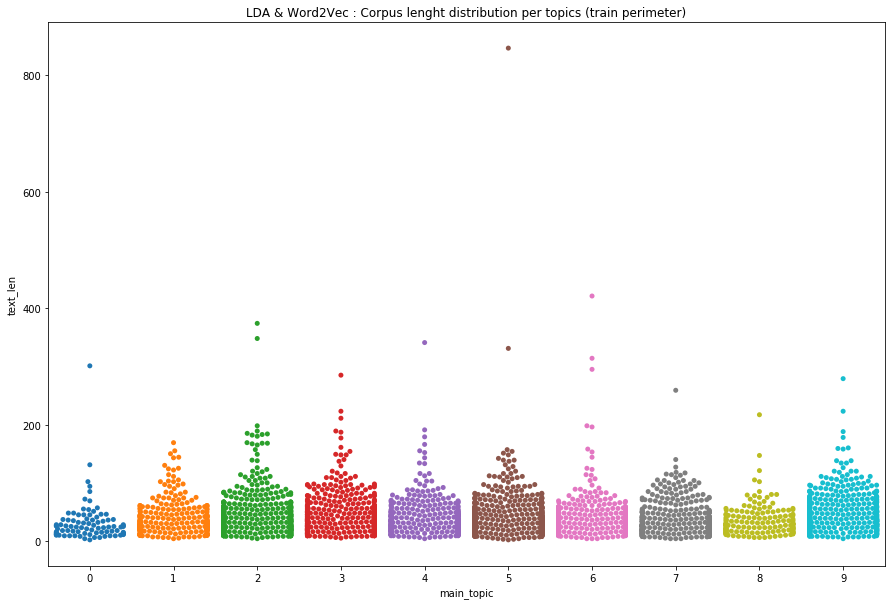

In [93]:
plt.figure(figsize=(15,10))
plt.title("LDA & Word2Vec : Corpus lenght distribution per topics (train perimeter)")
ax = sns.swarmplot(x="main_topic", y="text_len", data=df_train)

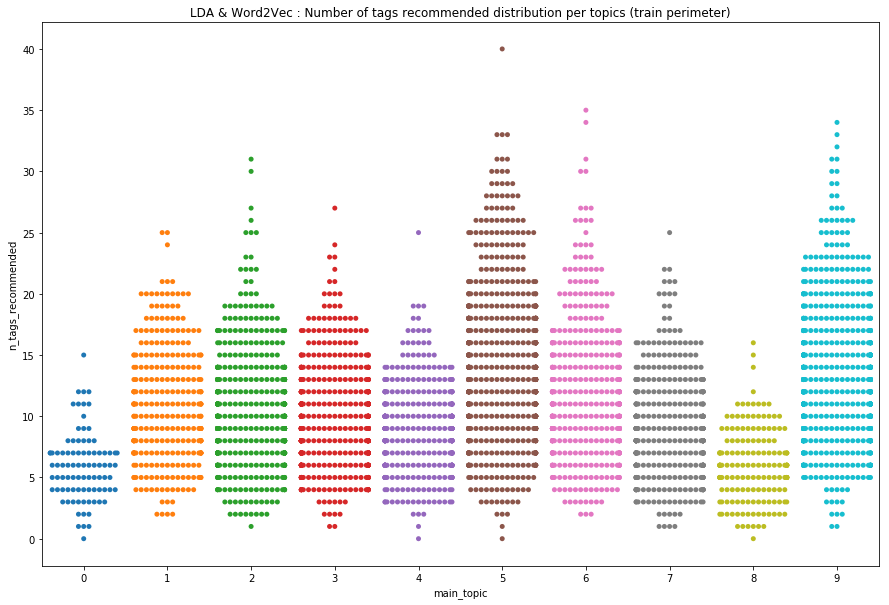

In [94]:
plt.figure(figsize=(15,10))
plt.title("LDA & Word2Vec : Number of tags recommended distribution per topics (train perimeter)")
ax = sns.swarmplot(x="main_topic", y="n_tags_recommended", data=df_train)

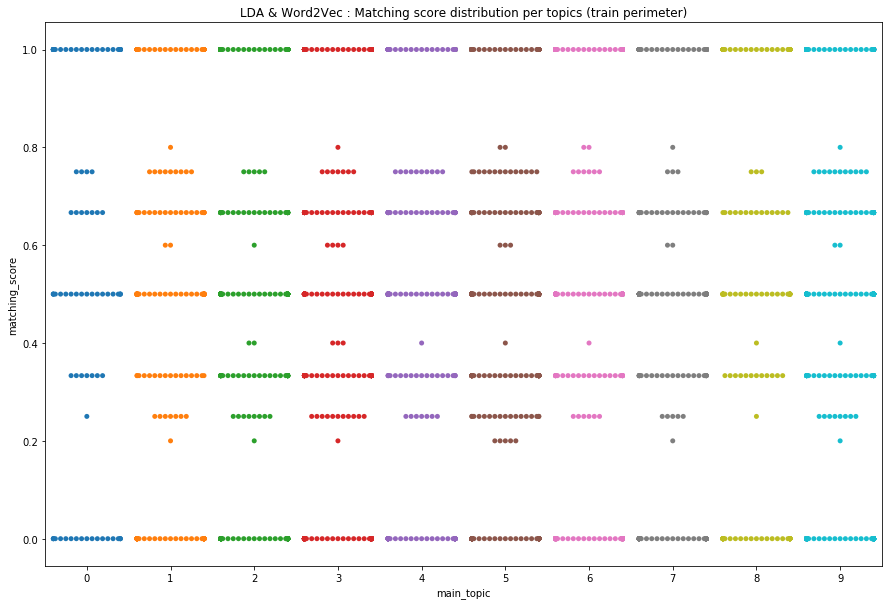

In [95]:
plt.figure(figsize=(15,10))
plt.title("LDA & Word2Vec : Matching score distribution per topics (train perimeter)")
ax = sns.swarmplot(x="main_topic", y="matching_score", data=df_train)

<p>
        **<font color='#D2691E'size="4">XIV) Prediction on the test data</font>**
</p>

In [96]:
df_test.head()

,id,Text,tag_list,corpus,text_len,unique_text_len,n_tags,tags_matching,n_tags_matching,matching_score
0,0,while applying opacity to a form should we use...,"[csharp, winforms]",apply opacity form use decimal double value us...,29,21,2,{},0,0.0
4,4,determine a user timezone is there any standar...,"[javascript, browser, html]",determine user timezone web server determine u...,14,10,3,{},0,0.0
8,8,what is the fastest way to get the value of π ...,"[performance, languageagnostic, unix, algorithm]",fast get value fast obtain value personal chal...,166,81,4,{},0,0.0
10,10,how to use the c socket api in c++ on z os ive...,"[sockets, c++, c]",use c socket api c++ z os get c sockets api pr...,87,64,3,"{c++, c, sockets}",3,1.0
19,19,how do i add existing comments to rdoc in ruby...,[ruby],add comments rdoc ruby format comments rdoc co...,15,10,1,{ruby},1,1.0


In [97]:
L_test_corpus = list(df_test['corpus'])

In [98]:
L_test_corpus[0:5]

['apply opacity form use decimal double value use change form opacity code decimal 5000 build application error implicitly type decimal double try using double control code past vbnet project',
 'determine user timezone web server determine user timezone web page perhaps http header string',
 'fast get value fast obtain value personal challenge specifically using involve using define constants like pi hardcoding number program tests various inline assembly version theory fast option clearly portable include compare versions tests version fast gcc constant specify version fast main testing program pitimesc pre prettyprintoverride include include ltstdioh include define define \\\\ diff 00 \\\\ clock \\\\ ++i \\\\ diff pi \\\\ clock \\\\ e time f diff \\\\ static inline double clock return double clock per sec int main int clock double diff case catch gcc folding pi use defined defined || defined extern double endif actual tests start return inline assembly x86 x64 systems pre double pi 

In [99]:
# Use count (raw term count) features for LDA in order to build the test bag of words :
print("Extracting count features for LDA...")
test_count_vectorizer = CountVectorizer(max_df=0.95, min_df=10, max_features=N_FEATURES)

start_time = time.time()
test_count = test_count_vectorizer.fit_transform(L_test_corpus)
test_vectorizer_feature_names = test_count_vectorizer.get_feature_names()
test_count_array = test_count.toarray()
df_all_test_words = pd.DataFrame(test_count_array, columns=test_vectorizer_feature_names)
print("--- %s seconds ---" % (time.time() - start_time))
df_all_test_words.head()

Extracting count features for LDA...
--- 0.0469050407409668 seconds ---


,10,100,11,2003,2005,2007,2008,30,35,50,...,worth,wouldnt,wpf,wrap,wrapper,xml,xp,year,yes,yet
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [100]:
#We get back the train columns schema :
df_final_test_words = df_train_words_space_schema.copy()
df_final_test_words

,09,10,100,11,12,15,2000,2003,2005,2007,...,wouldnt,wpf,wrap,xml,xp,year,yes,yet,youre,zip


In [101]:
#The original shape is :
test_words_dim = df_all_test_words.shape[1]
print("Original test space words dimension is %s"%test_words_dim)
#But we have to filter the data onto the train space perimeter
df_all_test_words = df_all_test_words[[col for col in df_all_test_words.columns if col in list(df_final_test_words.columns)]]
test_words_dim = df_all_test_words.shape[1]
print("After filtering on the train columns perimeter, test space words dimension is %s"%test_words_dim)
df_all_test_words.head()

Original test space words dimension is 867
After filtering on the train columns perimeter, test space words dimension is 782


,10,100,11,2003,2005,2007,2008,30,35,50,...,world,worth,wouldnt,wpf,wrap,xml,xp,year,yes,yet
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [102]:
#Finally, the test data looks like : 
df_final_test_words = df_final_test_words.append(df_all_test_words)
df_final_test_words.fillna(0, inplace=True)
df_final_test_words.head()

,09,10,100,11,12,15,2000,2003,2005,2007,...,wouldnt,wpf,wrap,xml,xp,year,yes,yet,youre,zip
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [103]:
test_matrix = df_final_test_words.values

In [104]:
test_results = lda.transform(test_matrix)
test_results[0:10]

array([[0.00434807, 0.00434911, 0.08781023, 0.0043488 , 0.09639488,
        0.42775559, 0.0043485 , 0.36194649, 0.00434914, 0.00434918],
       [0.00769281, 0.2508292 , 0.00769257, 0.00769368, 0.00769405,
        0.00769298, 0.00769538, 0.17813937, 0.31667639, 0.20819356],
       [0.00125039, 0.0012503 , 0.05840585, 0.00125031, 0.03346398,
        0.18793918, 0.1204227 , 0.41044931, 0.00125019, 0.18431779],
       [0.00175482, 0.00175466, 0.09764169, 0.00175465, 0.00175472,
        0.48211304, 0.0017548 , 0.29818575, 0.00175462, 0.11153123],
       [0.39868784, 0.00769333, 0.00769344, 0.00769442, 0.23221317,
        0.00769374, 0.31523896, 0.0076952 , 0.00769534, 0.00769456],
       [0.00192329, 0.00192361, 0.18047021, 0.29567122, 0.00192331,
        0.03674604, 0.00192327, 0.4755723 , 0.00192324, 0.00192352],
       [0.00400047, 0.00400086, 0.00400167, 0.0040003 , 0.00400018,
        0.65127869, 0.00400128, 0.18129069, 0.00400015, 0.13942571],
       [0.00434894, 0.20095313, 0.0043490

In [105]:
test_results[0]

array([0.00434807, 0.00434911, 0.08781023, 0.0043488 , 0.09639488,
       0.42775559, 0.0043485 , 0.36194649, 0.00434914, 0.00434918])

In [106]:
L_test_main_topics = []
for sub_result in test_results:
    max_idx = np.argmax(sub_result)
    L_test_main_topics.append(np.argmax(sub_result))
L_test_main_topics[0:10]

[5, 8, 7, 5, 0, 7, 5, 5, 6, 8]

In [107]:
df_test_corpus_topics = pd.DataFrame(test_results)
df_test_corpus_topics['id'] = list(df_test['id'])
df_test_corpus_topics['main_topic'] = L_test_main_topics
df_test_corpus_topics.head()

,0,1,2,3,4,5,6,7,8,9,id,main_topic
0,0.004348,0.004349,0.087810,0.004349,0.096395,0.427756,0.004349,0.361946,0.004349,0.004349,0,5
1,0.007693,0.250829,0.007693,0.007694,0.007694,0.007693,0.007695,0.178139,0.316676,0.208194,4,8
2,0.001250,0.001250,0.058406,0.001250,0.033464,0.187939,0.120423,0.410449,0.001250,0.184318,8,7
3,0.001755,0.001755,0.097642,0.001755,0.001755,0.482113,0.001755,0.298186,0.001755,0.111531,10,5
4,0.398688,0.007693,0.007693,0.007694,0.232213,0.007694,0.315239,0.007695,0.007695,0.007695,19,0


In [108]:
df_test = pd.merge(df_test,df_test_corpus_topics,how='left',on='id')
df_test.head()

,id,Text,tag_list,corpus,text_len,unique_text_len,n_tags,tags_matching,n_tags_matching,matching_score,...,1,2,3,4,5,6,7,8,9,main_topic
0,0,while applying opacity to a form should we use...,"[csharp, winforms]",apply opacity form use decimal double value us...,29,21,2,{},0,0.0,...,0.004349,0.087810,0.004349,0.096395,0.427756,0.004349,0.361946,0.004349,0.004349,5
1,4,determine a user timezone is there any standar...,"[javascript, browser, html]",determine user timezone web server determine u...,14,10,3,{},0,0.0,...,0.250829,0.007693,0.007694,0.007694,0.007693,0.007695,0.178139,0.316676,0.208194,8
2,8,what is the fastest way to get the value of π ...,"[performance, languageagnostic, unix, algorithm]",fast get value fast obtain value personal chal...,166,81,4,{},0,0.0,...,0.001250,0.058406,0.001250,0.033464,0.187939,0.120423,0.410449,0.001250,0.184318,7
3,10,how to use the c socket api in c++ on z os ive...,"[sockets, c++, c]",use c socket api c++ z os get c sockets api pr...,87,64,3,"{c++, c, sockets}",3,1.0,...,0.001755,0.097642,0.001755,0.001755,0.482113,0.001755,0.298186,0.001755,0.111531,5
4,19,how do i add existing comments to rdoc in ruby...,[ruby],add comments rdoc ruby format comments rdoc co...,15,10,1,{ruby},1,1.0,...,0.007693,0.007693,0.007694,0.232213,0.007694,0.315239,0.007695,0.007695,0.007695,0


<p>
        **<font color='#D2691E'size="4">XV) Tags generation on the test perimeter</font>**
</p>

In [109]:
df_test['lda_tags'] = df_test['main_topic'].apply(lambda x : dict_topics_tags[x])
df_test['lda_tags'][0:10]

0    [c++, visualstudio, c, languageagnostic, versi...
1    [aspnetmvc, webservices, rubyonrails, net35, n...
2    [sqlserver, c++, c, languageagnostic, webservi...
3    [c++, visualstudio, c, languageagnostic, versi...
4    [c, languageagnostic, rubyonrails, optimizatio...
5    [sqlserver, c++, c, languageagnostic, webservi...
6    [c++, visualstudio, c, languageagnostic, versi...
7    [c++, visualstudio, c, languageagnostic, versi...
8    [sqlserver, c++, visualstudio, c, languageagno...
9    [aspnetmvc, webservices, rubyonrails, net35, n...
Name: lda_tags, dtype: object

In [110]:
start_time = time.time()

df_test['recommendation'] = df_test.apply(lambda x : generate_tags(x['corpus'],
                                                                 df_lda_words_similarity,
                                                                 df_lda_tags_similarity,
                                                                 df_word2vec_words_similarity,
                                                                 df_word2vec_tags_similarity,
                                                                 df_word2vec_pure_tags_similarity,
                                                                 L_frequent_tags,
                                                                 5,
                                                                 x['lda_tags'],
                                                                 0.8),
                                            axis=1)


print("--- %s seconds ---" % (time.time() - start_time))
df_test['recommendation'][0:10]

--- 157.03023672103882 seconds ---


0    {codereview, agile, errorhandling, svn, versio...
1             {string, http, url, apache, webservices}
2    {c, batchfile, winapi, gcc, configuration, 64b...
3    {file, plugins, fileio, multithreading, c, io,...
4    {ubuntu, ruby, openid, rubyonrails, tags, reso...
5    {actionscript3, json, adobe, sql, string, date...
6    {bash, versioncontrol, cruisecontrolnet, versi...
7    {com, cocoa, cruisecontrolnet, delphi, winapi,...
8    {windowsvista, cvs, svn, tortoisesvn, shell, v...
9    {file, aspnetmvc, controls, iis, aspnetajax, c...
Name: recommendation, dtype: object

<p>
        **<font color='#D2691E'size="4">XVI) CHECKS on the test perimeter</font>**
</p>

In [111]:
df_test['n_tags_recommended'] = df_test.apply(lambda x : len(x['recommendation']),axis=1)
df_test['matching_tags_test'] = df_test.apply(lambda x : set(x['recommendation']).intersection(set(x['tag_list'])), axis=1)
df_test['matching_score_test'] = df_test.apply(lambda x : len(x['matching_tags_test'])/x['n_tags'], axis=1)
L_check_analysis = ['id','corpus','main_topic','text_len','tag_list','n_tags','tags_matching','matching_score',
                    'recommendation','n_tags_recommended','matching_tags_test','matching_score_test']
df_test[L_check_analysis].head()

,id,corpus,main_topic,text_len,tag_list,n_tags,tags_matching,matching_score,recommendation,n_tags_recommended,matching_tags_test,matching_score_test
0,0,apply opacity form use decimal double value us...,5,29,"[csharp, winforms]",2,{},0.0,"{codereview, agile, errorhandling, svn, versio...",17,{},0.0
1,4,determine user timezone web server determine u...,8,14,"[javascript, browser, html]",3,{},0.0,"{string, http, url, apache, webservices}",5,{},0.0
2,8,fast get value fast obtain value personal chal...,7,166,"[performance, languageagnostic, unix, algorithm]",4,{},0.0,"{c, batchfile, winapi, gcc, configuration, 64b...",13,{},0.0
3,10,use c socket api c++ z os get c sockets api pr...,5,87,"[sockets, c++, c]",3,"{c++, c, sockets}",1.0,"{file, plugins, fileio, multithreading, c, io,...",18,"{c++, c, sockets}",1.0
4,19,add comments rdoc ruby format comments rdoc co...,0,15,[ruby],1,{ruby},1.0,"{ubuntu, ruby, openid, rubyonrails, tags, reso...",7,{ruby},1.0


In [112]:
np.mean(df_test['n_tags_recommended'])

11.131759329779133

In [113]:
np.median(df_test['n_tags_recommended'])

10.0

In [114]:
np.mean(df_test['matching_score_test'])

0.6889565879664888

In [115]:
np.median(df_test['matching_score_test'])

1.0

In [116]:
np.mean(df_test['matching_score'])

0.5366844376745368

In [117]:
np.median(df_test['matching_score'])

0.5

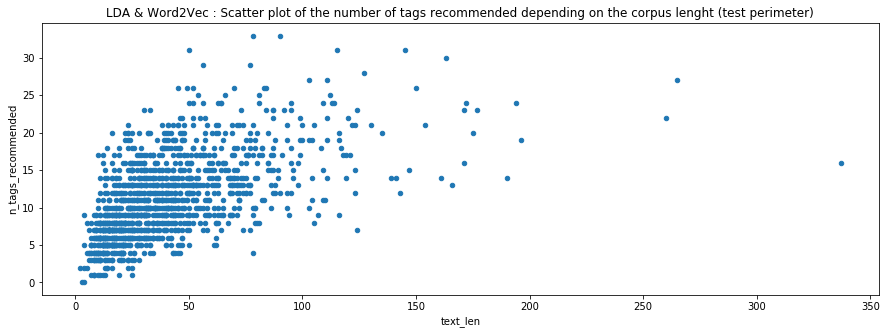

In [118]:
df_test.plot.scatter(x='text_len',
                     y='n_tags_recommended',
                     figsize=(15,5),
                     title = "LDA & Word2Vec : Scatter plot of the number of tags recommended depending on the corpus lenght (test perimeter)")

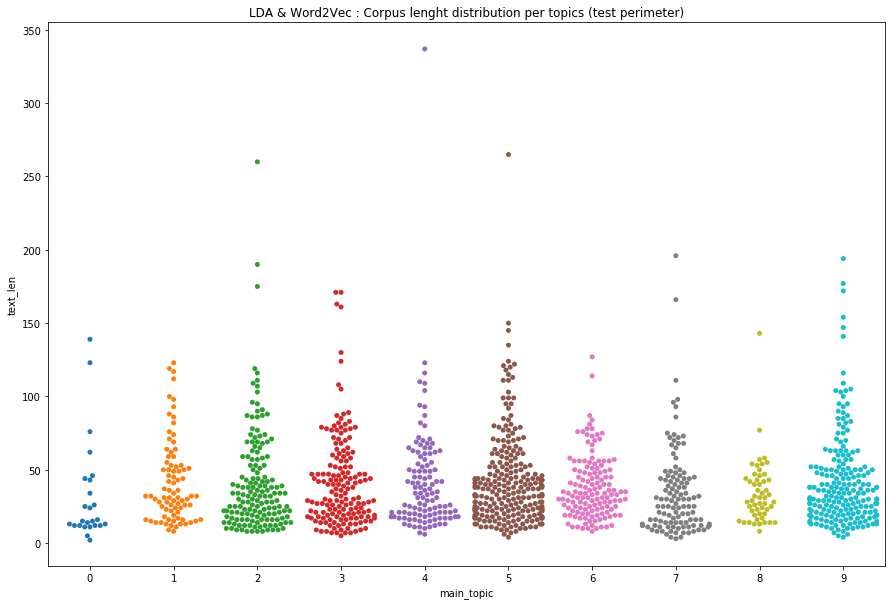

In [119]:
plt.figure(figsize=(15,10))
plt.title("LDA & Word2Vec : Corpus lenght distribution per topics (test perimeter)")
ax = sns.swarmplot(x="main_topic", y="text_len", data=df_test)

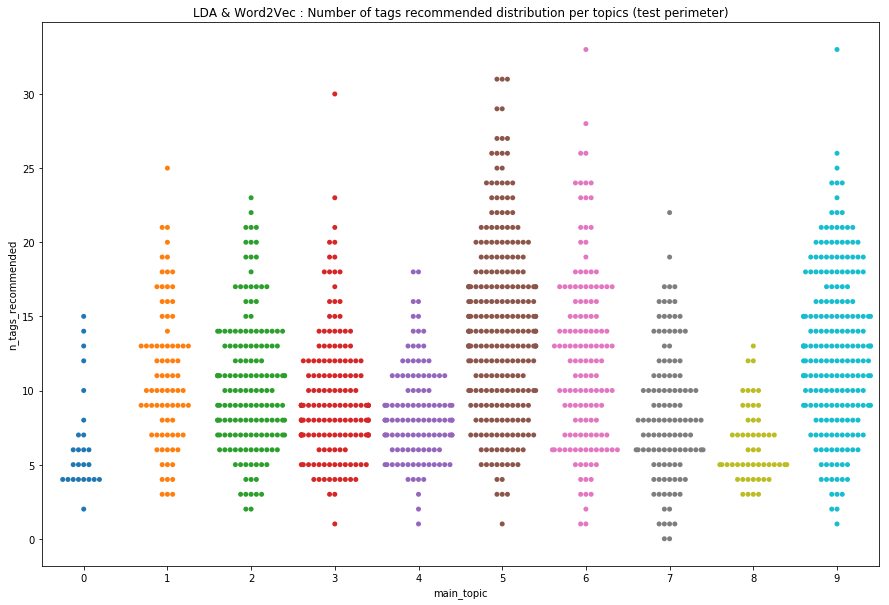

In [120]:
plt.figure(figsize=(15,10))
plt.title("LDA & Word2Vec : Number of tags recommended distribution per topics (test perimeter)")
ax = sns.swarmplot(x="main_topic", y="n_tags_recommended", data=df_test)

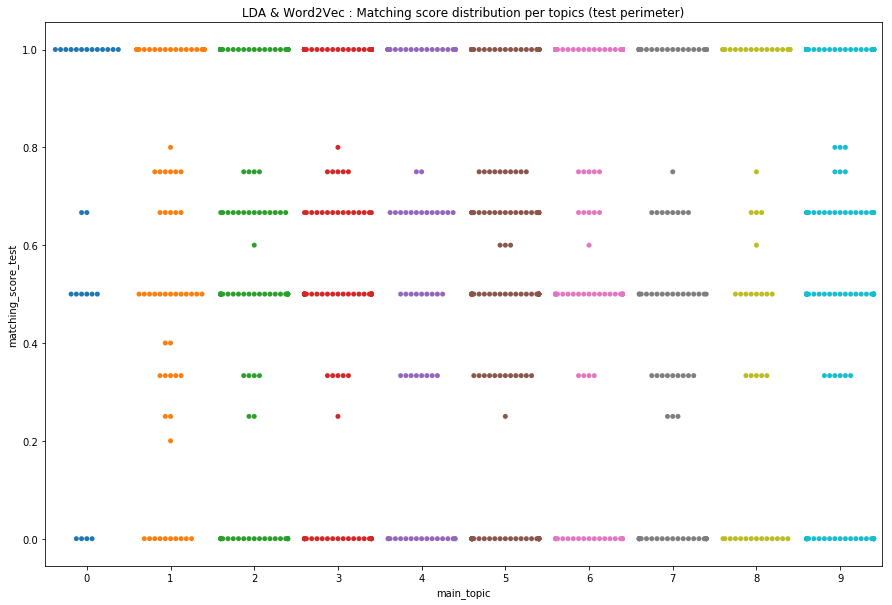

In [121]:
plt.figure(figsize=(15,10))
plt.title("LDA & Word2Vec : Matching score distribution per topics (test perimeter)")
ax = sns.swarmplot(x="main_topic", y="matching_score_test", data=df_test)

<p>
        **<font color='#D2691E'size="4">Dumping the models parameters</font>**
</p>

In [122]:
pickle.dump(df_train_words_space_schema,open(pickles_path+"df_train_words_space_schema.p", "wb"))

In [123]:
pickle.dump(lda,open(pickles_path+"lda_model.p", "wb"))

In [124]:
pickle.dump(dict_topics_tags,open(pickles_path+"dict_topics_tags.p", "wb"))
pickle.dump(dict_topics_words,open(pickles_path+"dict_topics_words.p", "wb"))

In [125]:
pickle.dump(df_lda_words_similarity,open(pickles_path+"df_lda_words_similarity.p", "wb"))
pickle.dump(df_lda_tags_similarity,open(pickles_path+"df_lda_tags_similarity.p", "wb"))

pickle.dump(df_word2vec_words_similarity,open(pickles_path+"df_word2vec_words_similarity.p", "wb"))
pickle.dump(df_word2vec_tags_similarity,open(pickles_path+"df_word2vec_tags_similarity.p", "wb"))

pickle.dump(df_word2vec_pure_tags_similarity,open(pickles_path+"df_word2vec_pure_tags_similarity.p", "wb"))